# Welcome to the ProcessMCRaT Example Notebook


### This notebook will walk through some of the ways that the ProcessMCRaT library can be used to process the output of a [MCRaT](https://github.com/lazzati-astro/MCRaT) simulation and conviently get and plot results quickly.

This notebook can be run interactively on your local machine if you:
1. Clone the git repository with 
```
git clone https://github.com/parsotat/ProcessMCRaT.git
```
2. After, the notebook can be accessed by navigating to the `notebook/` directory and running 
```
jupyter notebook
```
in the command line.

Alternatively, this notebook can be run remotely and interactively by opening it in Binder at the link: [https://mybinder.org/v2/gh/parsotat/ProcessMCRaT/HEAD?filepath=notebooks%2Fprocessmcrat_example.ipynb](https://mybinder.org/v2/gh/parsotat/ProcessMCRaT/HEAD?filepath=notebooks%2Fprocessmcrat_example.ipynb) When running the notebook on Binder, be sure to watch the memory usage of the notebook, in the upper right corner. If the memory usage exceeds 2 GB, then the notebook will crash and you will need to refresh the link.

In either case the steps below will help you get an understanding of how to setup and use the ProcessMCRaT python package.

### 1. First we need to install the package which can be done using *pip*

In the command line you would run `pip install processmcrat` or from a jupyter notebook you would run the line below:

In [ ]:
!pip install processmcrat

### 2. With the package now installed on your local machine or in the Binder environment we can now import the package alongside other packages that we will need to analyze a given MCRaT simulation

In [1]:
import processmcrat as pm
import astropy.units as unit
from astropy import constants as const
import matplotlib.pyplot as plt
import numpy as np
#in your own python or ipython script you may want to set plt.ion() for interactive plots

Run the next line for interactive plots:

In [2]:
%matplotlib notebook

### 3. Now that we have loaded everything, we need a MCRaT simulation file to analyze. We will download one such file into this directory from the variable *40sp_down* simulation that includes polarization and cyclo-synchrotron emission and absorption. The simulation file correponds to the last frame of the hydrodynamic simulation and we will produce mock observations from it.

In [3]:
#here we will download the mcdata file needed for this example 
import gdown
url = 'https://drive.google.com/uc?id=12ZtMIMeLKp03Uiohfze52UBwmVJmoje0'
output = 'mcdata_1999.h5'
gdown.download(url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=12ZtMIMeLKp03Uiohfze52UBwmVJmoje0
From (redirected): https://drive.google.com/uc?id=12ZtMIMeLKp03Uiohfze52UBwmVJmoje0&confirm=t&uuid=34a663e2-58bf-4094-bef3-4dd8a9723f2b
To: /Users/tparsotan/Library/CloudStorage/Box-Box/Theory-Interface/mcdata_1999.h5
100%|████████████████████████████████████████| 823M/823M [00:39<00:00, 20.7MB/s]


'mcdata_1999.h5'

We first need to create a MCRaT simulation load object that will hold all the information in the mcdata file. We pass the location of the directory that holds the simulation's mcdata files. If we dont pass any file directory then the library assumes that the mcdata file(s) are in the current working directory.

In [4]:
mcrat_sim=pm.McratSimLoad() 

if the mcdata files are located in `/Volume/dir/to/mcrat/sim`, we would instead do `pm.McratSimLoad('/Volume/dir/to/mcrat/sim')`  

Now we need to specify which frame we want to load and whether we want to load any other optional data such as stokes parameters, comoving four momenta, or the photon type. For our example analysis, the last frame of the hydro simulation is frame 1999 which is the last frame of the MCRaT simulation as well. Additionally, we only want to load in the stokes parameters to calculate polarizations later on. By leaving out the `read_comv` and `read_type` keywords, they are assumed to be `False`. We will see that by setting `read_stokes=True` the output of the functions that create mock observations will automatically include polarization calculations.

In [5]:
mcrat_sim.load_frame(1999, read_stokes=True)

The `mcrat_sim` object now holds all the information for all the MCRaT photons and various quantities can be accessed of desired. We can get one of the following quantities: 
* lab frame 4 momenta (*p0, p1, p2, p3*), 
* location of each photon in cartesian coordinates of x,y, and z (*r0, r1, r2*), 
* weights (*weight*), 
* number of scatterings experienced by each photon (*scatterings*), 
* location of the photon in the original hdf5 mcdata file (*file_index*)
* comoving fluid frame 4 momenta if loaded (*comv_p0, comv_p1, comv_p2, comv_p3*),
* photon type if loaded (*photon_type*)
* and the stokes parameters if loaded (*s0, s1, s2, s3*)

The quantities are accessed from the `mcrat_sim` object as `mcrat_sim.loaded_photons.x`, where x is any of the italicised identifiers listed above. For example, if we want to see the photon energies we can do:

In [6]:
print(mcrat_sim.loaded_photons.p0*(const.c.cgs.value))

[5.27059383e-08 1.26476577e-08 6.22665414e-09 ... 2.00832919e-12
 2.74379951e-12 6.48917431e-13]


Here we see that the loaded photons' 4-momenta are normalized by c, the speed of light in cgs units, which is how they are stored in the MCRaT simulations. We can get thier energies in erg simply by multiplying by c.

Since the energies are something that is typically analyzed, the `mcrat_sim.loaded_photons`, which is an instance of the PhotonList class, has a method associated with it that allows us to quickly calculate the energies of the photons. It can be called as:

In [7]:
print(mcrat_sim.loaded_photons.get_energies()) #for comoving energies of the photons, the function is: get_comv_energies()

[3.28964592e+01 7.89404701e+00 3.88637183e+00 ... 1.25350049e-03
 1.71254496e-03 4.05022403e-04]


By default, the energy is calculated in units of keV, but by passing an applicable astropy unit to the function, the energy will be appropriately calculated. For example, to calculate the units in ergs, we do

In [8]:
print(mcrat_sim.loaded_photons.get_energies(unit=unit.erg))

[5.27059383e-08 1.26476577e-08 6.22665414e-09 ... 2.00832919e-12
 2.74379951e-12 6.48917431e-13]


If we want a wavelength, we can also do that.

In [9]:
print(mcrat_sim.loaded_photons.get_energies(unit=unit.angstrom))

[3.76892229e-01 1.57060375e+00 3.19022996e+00 ... 9.89103712e+03
 7.23976314e+03 3.06116890e+04]


#### An aside about units

This brings us to an important aside about units used in ProcessMCRaT. The package assigns appropriate astropy units to various quantities to make sure that various calculations are done consistently. It is beneficial for the user to read some of the excellent documentation that the astropy collaboration has on their implementation of units as it will help aid in understanding the ProcessMCRaT library. This documentation can be found at [https://docs.astropy.org/en/stable/units/](https://docs.astropy.org/en/stable/units/)

### 4. Conduct a Mock Observation
With a basic understanding of the McratSimLoad object and its use in loading in simulation data, we can create a mock observation with the photons. To do that we create a MockObservation object. This object, holds all the data for:
* where an observer is located with respect to the jet axis, $\theta_\mathrm{v}$, 
* the acceptance angle of the observer $\Delta \theta$, meaning that photons that are moving towards the observer in the range [$\theta_\mathrm{v}-0.5\Delta \theta, \theta_\mathrm{v}+0.5\Delta \theta$) are considered to be detected
* the location of the observer, $r_\mathrm{d}$, 
* the number of frames per second in the hydrodynamic simulation that was analyzed, $\mathrm{fps}$,
* the number of dimensions of the hydrodynamic simulation, and
* all of the data for photons detected by the observer at $\theta_\mathrm{v}$

For the *40sp_down* simulation, we would make a mock observation as:

In [10]:
observation=pm.MockObservation(1, 1, 1e13, 10, mcratsimload_obj=mcrat_sim)

where the first variable passed to the observation function is $\theta_\mathrm{v}$ in degrees, the second is $\Delta \theta$ in degrees, the third is $r_\mathrm{d}$ in cm, the fourth is fps. The last argument is the McratSimLoad object that contains all the loaded photons' data. We did not specify the number of dimensions in the call because the default is set to 2D. If the hydro simulation was in 3D, which will be supported in the future, you would have `hydrosim_dim=3` keyword as one of the arguments. 

The mock observation function call calculates which photons are moving towards the observer in the angle range specified previously. For these detected photons, their detection time, $t_d$, is calculated as:
$t_d=t_\mathrm{real} + t_p - t_j$, where $t_\mathrm{real}$ is the lab frame time of the hydrodynamic frame that has been loaded, $t_j$ is the jet detection time which is calculated by considering a virtual photon propagating to $r_\mathrm{d}$ at the time that the jet is initially launched. Finally, $t_p$ is the time that it will take photons to propagate towards $r_\mathrm{d}$ from their location in the loaded MCRaT frame.

Like the McratSimLoad object that we were exploring earlier, the MockObservation object that we created contains all the information for the detected photons. We can get all the same photon data as before with the addition of each photons' detection time. To access this data we would do:

In [11]:
print(observation.detected_photons.p0)

[1.10302427e-18 1.17673392e-18 6.61093762e-19 ... 5.72090955e-22
 3.51041574e-22 1.38124376e-22]


In [12]:
print(observation.detected_photons.detection_time)

[11.71451412 11.75636985 11.7353675  ... 39.34003975 39.32799425
 39.45023833]


In order to easily save our observations, we can create event files. These event files only contain information about the detected photons at the user specified $\theta_\mathrm{v}$ which allow them to be smaller than the MCRaT mcdata files that can be very large and difficult to send to collaborators, for example. These files can be loaded as an observation object, allowing for continued analysis of the data. 

In order to create an event file, we can do:

In [13]:
observation.save_event_file('40sp_down')

In [14]:
!ls

40sp_down_1.00e+13_1.evt   mcdata_1999.h5
LICENSE                    processmcrat_example.ipynb
README.md                  sim_build.yml
database_store             test_params.yml


We can see that the event file has been created. It is a text file with the .evt extension. The file name contains the identifier that we passed to the `save_event_file` function followed by $r_\mathrm{d}$ and $\theta_\mathrm{v}$ for the observation. If we wanted the event file to be saved elsewhere, then we can also specify the directory using the `save_directory` optional keyword. For example, to save the file in your downloads folder you would do `observation.save_event_file('40sp_down', save_directory='~/Downloads/')`.

Using the event file, you or a collaborator can load it to create the same observation object that we created above from the McratLoadSim object. Instead of running `observation=pm.MockObservation(1, 1, 1e13, 10, mcratsimload_obj=mcrat_sim)` we would do:
```
observation=pm.MockObservation(1, 1, 1e13, 10, id='40sp_down', directory='path/to/dir/with/eventfile/')
```
where we still provide the same inputs related to the observer and the hydrosimulation, but we specify the id of the observation and the directory that the event file exists in. If the event file is in the current working directory, the directory keyword can be left out.

In [15]:
!rm 40sp_down_1.00e+13_1.evt #since we wont be using this file in this notebook we will remove it

### 5. Create Mock Observables
Once we have conducted our mock observation we can create mock observables. These include producing light curves, spectra, and polarizations. We use the observation object directly to acquire these observables.

#### Calculating Spectra
In order to calculate time integrated spectra, from t=0 to t=45 s for our mock observed GRB, we simply do:

In [16]:
spectrum_dict=observation.spectrum(0, 45)

/Users/tparsotan/anaconda3/lib/python3.10/site-packages/processmcrat/mockobservations.py:944: RuntimeWarning: invalid value encountered in sqrt
  sigma_Q_r = np.sqrt(var_factor * (mu_factor / mu - Q_r ** 2))
/Users/tparsotan/anaconda3/lib/python3.10/site-packages/processmcrat/mockobservations.py:962: RuntimeWarning: invalid value encountered in sqrt
  sigma_pr = np.sqrt((partial_pr_Qr * sigma_Q_r) ** 2 + (
/Users/tparsotan/anaconda3/lib/python3.10/site-packages/processmcrat/mockobservations.py:964: RuntimeWarning: invalid value encountered in sqrt
  sigma_chi = np.sqrt((partial_phir_Qr * sigma_Q_r) ** 2 + (


This returns a dictionary object that contains all of the information in the spectrum. We can see what information there is by running:

In [17]:
print(spectrum_dict.keys())

dict_keys(['spectrum', 'spectrum_errors', 'ph_num', 'num_scatt', 'energy_bin_center', 'theta_observer', 'pol_deg', 'stokes_i', 'stokes_q', 'stokes_u', 'stokes_v', 'pol_angle', 'pol_deg_errors', 'pol_angle_errors'])


which shows that we have the spectrum, its errors, the number of photons in each spectral bin, the center of each energy bin that was used to construct the spectra, the stokes parameters, the calculated polarization degree and angles in each energy bin and their errors, and the observer viewing angle for this mock observation. The polarization related keys are automatically included since we had set `read_stokes=True` when we read in the MCRaT data.

In order to access any of this information we simply do `spectrum_dict[X]` where X is any of the previously listed keys. For example, if we want to look at the spectrum and the energies that the spectral intensities correspond to we do

In [18]:
print(spectrum_dict['spectrum'])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.36807565e+39 1.15069088e+41 3.99172198e+41 2.54927656e+42
 6.62277000e+42 1.13376629e+43 2.47760310e+43 7.21754766e+43
 4.97190729e+43 1.49619997e+44 7.38086794e+43 1.33447599e+44
 1.58281109e+44 1.83923923e+44 1.73517200e+44 2.40238226e+44
 1.87410105e+44 2.80024539e+44 2.20203239e+44 1.85754532e+44
 1.68624011e+44 1.74963905e+44 3.77062628e+44 1.13932043e+45
 2.76354037e+44 9.953201

In [19]:
print(spectrum_dict['energy_bin_center'])

[1.12201845e-07 1.41253754e-07 1.77827941e-07 2.23872114e-07
 2.81838293e-07 3.54813389e-07 4.46683592e-07 5.62341325e-07
 7.07945784e-07 8.91250938e-07 1.12201845e-06 1.41253754e-06
 1.77827941e-06 2.23872114e-06 2.81838293e-06 3.54813389e-06
 4.46683592e-06 5.62341325e-06 7.07945784e-06 8.91250938e-06
 1.12201845e-05 1.41253754e-05 1.77827941e-05 2.23872114e-05
 2.81838293e-05 3.54813389e-05 4.46683592e-05 5.62341325e-05
 7.07945784e-05 8.91250938e-05 1.12201845e-04 1.41253754e-04
 1.77827941e-04 2.23872114e-04 2.81838293e-04 3.54813389e-04
 4.46683592e-04 5.62341325e-04 7.07945784e-04 8.91250938e-04
 1.12201845e-03 1.41253754e-03 1.77827941e-03 2.23872114e-03
 2.81838293e-03 3.54813389e-03 4.46683592e-03 5.62341325e-03
 7.07945784e-03 8.91250938e-03 1.12201845e-02 1.41253754e-02
 1.77827941e-02 2.23872114e-02 2.81838293e-02 3.54813389e-02
 4.46683592e-02 5.62341325e-02 7.07945784e-02 8.91250938e-02
 1.12201845e-01 1.41253754e-01 1.77827941e-01 2.23872114e-01
 2.81838293e-01 3.548133

We can immediately see that each of these quantities have units associated with them. The units were implicitly passed to the spectrum function when we called it. To see the defaults of the spectrum method, we can run

In [20]:
observation.spectrum?

From the docstring that pop ups, we saw that the default units of `spectrum_unit` was erg/s/keV, the energy range over which the spectrum was calculated was from [$10^{-7}$, $10^{5}$] keV with step sizes of $10^{0.1}$ keV. The default energy units are in keV, which is the energy unit for the calculated spectrum. These defaults can be changed by passing in the values that we want. If we wanted the spectrum to be calculated from [$10^{2}$, $10^{8}$] eV with units of counts/s/eV then we set `spectrum_unit=unit.count/unit.s/unit.eV` and `energy_range=[10**2, 10**8]*unit.eV`, and `delta_energy=1.26*unit.eV`. We need to ensure that the units of the `energy_range` and the `delta_energy` parameters are the same. Thus our function call would look like:

In [21]:
spect_count_dict=observation.spectrum(0, 45, spectrum_unit=unit.count/unit.s/unit.eV,\
                                      energy_range=[10**2, 10**8]*unit.eV, delta_energy=1.26*unit.eV)
print(spect_count_dict['spectrum'], spect_count_dict['energy_bin_center'])

[9.58716927e+50 7.60217855e+50 1.27715676e+51 3.44618658e+51
 5.99863755e+50 1.79809310e+51 9.12608717e+50 4.79026361e+51
 3.66572776e+51 1.14761458e+52 1.06177918e+52 1.48474773e+52
 3.72789503e+52 5.84574845e+52 8.67784110e+52 7.33490352e+52
 9.53100133e+52 1.07108120e+53 1.45971632e+53 1.21982676e+53
 1.23645896e+53 1.32094920e+53 1.24440548e+53 1.19429575e+53
 1.21301026e+53 1.27243106e+53 1.11598803e+53 9.77408446e+52
 8.47184732e+52 7.08875496e+52 5.79467022e+52 4.55768502e+52
 3.30827976e+52 2.34013298e+52 1.54292752e+52 9.15979721e+51
 5.09108018e+51 2.65690718e+51 1.39399225e+51 6.75715887e+50
 3.41646414e+50 1.96442377e+50 1.04149994e+50 5.66247177e+49
 2.56691169e+49 1.14568606e+49 5.26230692e+48 2.67195369e+48
 1.30870627e+48 8.95076243e+47 4.53082872e+47 1.76187698e+47
 1.19950287e+47 4.38553632e+46 1.78273569e+46 3.36873713e+45
 5.34720179e+45 0.00000000e+00 0.00000000e+00 0.00000000e+00] ct / (eV s) [1.12249722e+02 1.41434649e+02 1.78207658e+02 2.24541649e+02
 2.82922478

The times that are passed into the spectrum method can correspond to any times within the active period of the mock observed GRB which allows us to also create mock observed time resolved spectra. 


One of the most important things that is done with time resolved and time integrated spectra is fitting them with models (the code is only able to fit spectra with the Band and Comptonized functions at this time). **In order to do this, we have to give some information related to the fitting of the spectra. One this is done, we call the spectrum method where the units of the spectra need to be in counts/s/energy_unit. We also need to let the spectrum function that we want to do the spectral fitting.** To get a spectrum and its fitted Band or Comptonized function parameters we do:

In [22]:
observation.set_spectral_fit_parameters()

By running the code below, we can see that we just initalized the spectral energy range that we want the spectral fitting to occur over to be from 8 to 40000 keV. We also specified that we want to fit any energy bins that have greater than 10 photons in them, as that will allow us to assume that the errors in those bins are gaussian for the fitting technique used here. If you would like to change any of these parameters simply set each keyword to the values that you want when calling the `set_spectral_fit_parameters` method. For example, if we wanted to fit spectra from 8-300 eV, with either the Band or Comptonized functions, for energy bins with at least 20 photons in them we would do `observation.set_spectral_fit_parameters(spectral_fit_energy_range=[8,300]*unit.eV, approx_gaussian_error_num=20)`

In [23]:
observation.set_spectral_fit_parameters?

In [24]:
spectrum_dict=observation.spectrum(0, 45, spectrum_unit=unit.count/unit.s/unit.keV, fit_spectrum=True, sample_num=1e4)

/Users/tparsotan/anaconda3/lib/python3.10/site-packages/processmcrat/mclib.py:48: RuntimeWarning: invalid value encountered in double_scalars
  model[kk]=((alpha-beta)*break_energy)**(alpha-beta)*energies[kk]**(beta)*np.exp(beta-alpha)


In [25]:
print(spectrum_dict.keys())

dict_keys(['spectrum', 'spectrum_errors', 'ph_num', 'num_scatt', 'energy_bin_center', 'theta_observer', 'pol_deg', 'stokes_i', 'stokes_q', 'stokes_u', 'stokes_v', 'pol_angle', 'pol_deg_errors', 'pol_angle_errors', 'fit', 'fit_errors', 'model_use'])


We can now see that there are new keys for the spectral fit, the errors in the spectral fitted parameters, and the type of model that provides the superior fit (either 'b' for Band or 'c' for Comptonized function, as of now). As is shown below, the value for the 'fit' key gives another dictionary with the fitted $\alpha$, $\beta$ (if applicable), break energy, and normalizations. The value for the 'fit_errors' key gives another dictionary with the fitted $\alpha$, $\beta$ (if applicable), and break energy $1\sigma$ errors that have been acquired by bootstrapping a number of times corresponding to the `sample_num` keyword that was passed to the spectrum method.

In [26]:
print(spectrum_dict['fit'], spectrum_dict['fit_errors'])
print(r'The best fit spectrum is a', spectrum_dict['model_use'], r'The best fit $\alpha$ is ',\
      spectrum_dict['fit']['alpha'], 'with an error of', spectrum_dict['fit_errors']['alpha_errors'])

{'alpha': -0.12774418996180945, 'beta': -2.8652037023446106, 'break_energy': <Quantity 150.73819066 keV>, 'normalization': 1.841846047716811e+58} {'alpha_errors': 0.014637850982227958, 'beta_errors': 0.012485419598579744, 'break_energy_errors': <Quantity 2.22484245 keV>}
The best fit spectrum is a b The best fit $\alpha$ is  -0.12774418996180945 with an error of 0.014637850982227958


In order to calculate the spectral peak energy, we can use the included `calc_epk_error` function. For example:

In [27]:
peak_e, peak_e_err = pm.calc_epk_error(spectrum_dict['fit']['alpha'], spectrum_dict['fit']['break_energy'],\
                                        alpha_error=spectrum_dict['fit_errors']['alpha_errors'],\
                                        break_energy_error=spectrum_dict['fit_errors']['break_energy_errors'])
print(peak_e, peak_e_err)

282.2204532609345 keV 4.713782273308056 keV


The last keyword that can be passed to the spectrum method that has not been discussed as of yet is the `photon_type`. As a default is set to `None` which means that all types of photons are included in the construction of the spectrum, both 'i' and 'c' types ([see Section 3.3 of the MCRaT documentation](https://github.com/lazzati-astro/MCRaT/blob/master/Doc/mcrat_doc.pdf)) for injected photons and cyclo-synchrotron photons. If the user wants to analyze either of these populations of photons they can set `photon_type='i'` or `photon_type='c'`.

If you want to use different parameters for calculating spectra later on in your analysis, you can simply recall the observation.set_spectral_fit_parameters with new values for spectral_fit_energy_range, spectral_fit_energy_unit, and/or approx_gaussian_error_num.

We have also included conenience functions to calculate the Band and Comptonized functions for a given set of parameters, thus the results of the spectral fits can be sent to these functions with energy ranges and you will be able to reconstruct the best fit spectrum. More information can be found by doing:

In [28]:
pm.band_function?

In [29]:
pm.comptonized_function?

#### Calculating Polarization

In order to calculate the time integrated polarization, we can simply do:

In [30]:
time_int_pol=observation.polarization(0,45)

This gives us another dictionary with a subset of the keys that the spectrum method provided. As is shown below, we get the stokes parameters, the polarization degree and angles, as well as the $1\sigma$ errors of those mock observations.

In [31]:
print(time_int_pol.keys())

dict_keys(['stokes_i', 'stokes_q', 'stokes_u', 'stokes_v', 'pol_deg', 'pol_angle', 'pol_deg_errors', 'pol_angle_errors', 'theta_observer'])


Time resolved polarizations can be calculated simply by changing the time bins that the photons are collected within. If we want to calculate the polarization for a given type of photon in the simulation, we can also pass the `photon_type` keyword into our method call, the same as what we would do for calculating a spectrum.

Similar to the way that we can specify an energy range to calculate the spectra within, we can also specify an energy range over which the polarization is calculated. This is done by setting the `energy_range` parameter when calling the `polarization` method. For example, if we wanted to calculated the time integrated polarization in the optical enegies from 1.5-7.7 eV then we would do:

In [32]:
print(observation.polarization(0,45, energy_range=[1.5,7.7]*unit.eV))

{'stokes_i': <Quantity 1.>, 'stokes_q': <Quantity -0.25713576>, 'stokes_u': <Quantity -0.01705302>, 'stokes_v': <Quantity 0.>, 'pol_deg': <Quantity 0.25770061>, 'pol_angle': <Quantity -88.10287526 deg>, 'pol_deg_errors': <Quantity 0.17614188>, 'pol_angle_errors': <Quantity 21.0030049 deg>, 'theta_observer': <Quantity 1. deg>}


#### Calculating Light Curves

Calculating light curves is just as easy as calculating spectra and polarization. To get the light curve that an observer located at $\theta_\mathrm{v}=1^\circ$ would detect from our *40sp_down* simulated GRB, from 10 s after the jet was launched to 40 s after the jet was launched in uniform time bins, we would do:

In [33]:
lightcurve_dict=observation.lightcurve(time_start=10, time_end=40, dt=0.2)
print(lightcurve_dict.keys())

dict_keys(['lightcurve', 'lightcurve_errors', 'ph_num', 'num_scatt', 'times', 'theta_observer', 'pol_deg', 'stokes_i', 'stokes_q', 'stokes_u', 'stokes_v', 'pol_angle', 'pol_deg_errors', 'pol_angle_errors'])


/Users/tparsotan/anaconda3/lib/python3.10/site-packages/processmcrat/mockobservations.py:945: RuntimeWarning: invalid value encountered in sqrt
  sigma_U_r = np.sqrt(var_factor * (mu_factor / mu - U_r ** 2))


Looking at the various keys in the dictionary we can see that we get similar keys as from the previous dictionaries. The difference here is that the output quantities are functions of time. The times that we get define the time bins that photons are collected within to produce the lightcurves, polarization, and other quantities. 

If we wanted to produce the light curve using variable time bins, we can set `variable_t_bins=True` such as:

In [34]:
lightcurve_dict=observation.lightcurve(time_start=10, time_end=40, dt=0.2, variable_t_bins=True)

Alteratively, if you have an array that defines the time bins that you would like the light curve and other quantities to be calculated from, you can pass that information instead as:

In [35]:
t=np.arange(10, 40, 2)
lightcurve_dict=observation.lightcurve(time_array=t)
print(lightcurve_dict['times'])
print(lightcurve_dict['lightcurve'])

[10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38.] s
[1.92819701e+50 1.23556147e+51 7.42321226e+51 1.64228460e+52
 2.60733348e+52 2.02173787e+52 4.38153960e+51 3.51963894e+50
 4.63159894e+51 1.71619258e+52 3.34410690e+51 1.81196655e+51
 7.53237440e+51 8.59770283e+51 0.00000000e+00] erg / s


We can see that the times have been used to calculate the lightcurve. The default calculation of the lightcurve produces values that have units of erg/s however the light curve can also be set to counts/s by setting `lc_unit=unit.count/unit.s`. These light curves were calculated without any energy cuts making them bolometric light curves however, we can also calculate the light curve for a specific energy range of photons. For example if we wanted to calculate the light curve from 10-1000 eV we would do something like:

In [36]:
lightcurve_dict=observation.lightcurve(time_start=10, time_end=40, dt=0.2, energy_range=[10, 1000]*unit.eV)

For each time bin we can also calculate the time resolved spectrum and fit the spectra from each time bin. In order to do this, we set `fit_spectrum=True`. This can take a little while to calculate based on the `spectral_sample_num` value. This is identical to the `sample_num` keyword that gets passed to the `spectrum` method. To minimize the wait time in this notebook, we have decreased the number of time bins that will have spectra that need to be fitted.

In [37]:
lightcurve_dict=observation.lightcurve(time_start=10, time_end=40, dt=1, fit_spectrum=True)

Fitting between times: 10 11
Fitting between times: 11 12


/Users/tparsotan/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fitting between times: 12 13


/Users/tparsotan/anaconda3/lib/python3.10/site-packages/processmcrat/mclib.py:152: RuntimeWarning: overflow encountered in exp
  model=(energies**alpha)*np.exp(-energies/break_energy)
/Users/tparsotan/anaconda3/lib/python3.10/site-packages/processmcrat/mclib.py:153: RuntimeWarning: invalid value encountered in divide
  model=model/np.trapz(model,x=energies)*normalization
/Users/tparsotan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4832: RuntimeWarning: overflow encountered in multiply
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
/Users/tparsotan/anaconda3/lib/python3.10/site-packages/processmcrat/mclib.py:152: RuntimeWarning: overflow encountered in power
  model=(energies**alpha)*np.exp(-energies/break_energy)
/Users/tparsotan/anaconda3/lib/python3.10/site-packages/processmcrat/mclib.py:152: RuntimeWarning: overflow encountered in multiply
  model=(energies**alpha)*np.exp(-energies/break_energy)


Fitting between times: 13 14
Fitting between times: 14 15
Fitting between times: 15 16
Fitting between times: 16 17
Fitting between times: 17 18
Fitting between times: 18 19
Fitting between times: 19 20
Fitting between times: 20 21
Fitting between times: 21 22
Fitting between times: 22 23
Fitting between times: 23 24
Fitting between times: 24 25
Fitting between times: 25 26
Fitting between times: 26 27
Fitting between times: 27 28
Fitting between times: 28 29
Fitting between times: 29 30
Fitting between times: 30 31
Fitting between times: 31 32
Fitting between times: 32 33
Fitting between times: 33 34
Fitting between times: 34 35
Fitting between times: 35 36
Fitting between times: 36 37
Fitting between times: 37 38
Fitting between times: 38 39


In [38]:
print(lightcurve_dict.keys())

dict_keys(['lightcurve', 'lightcurve_errors', 'ph_num', 'num_scatt', 'times', 'theta_observer', 'pol_deg', 'stokes_i', 'stokes_q', 'stokes_u', 'stokes_v', 'pol_angle', 'pol_deg_errors', 'pol_angle_errors', 'fit', 'fit_errors', 'model_use'])


We can now see that there are new keys in the returned dictionary related to the spectral fittings. We can access the fitted alphas by doing:

In [39]:
print(lightcurve_dict['fit']['alpha'])

[        nan         nan         nan -1.01975141  0.08957336  0.7882504
  0.16692294  0.36966606  0.28598678  0.49229542  0.3495879   0.90465995
 -0.20238012         nan         nan  0.5497438   1.62145538 -0.14323719
  0.75339459  0.63746673  0.70831604  0.94587138 -0.29913806  0.59552189
  0.34595629  0.76061075  0.81802063  0.48719408  0.75225275         nan]


With producing these mock observables, it becomes tedious to constantly enter a certain spectral energy range that you would like the spectra to be calculated within, or light curve energy range, or detected polarization energy range to simulate what energy ranges a given instrument would make its measurements in. In order to simplify this, the ProcessMCRaT code allows you to create an instrument with these parameters defined. Then, we can load this instrument into each of our observation objects which will automatically apply the instrumental energy constraints for each mock observable that is produced. 

Lets create a Polar-2/Fermi mash-up instrument, which would measure polarization from 20-800 keV, spectra from 8 keV-40 MeV, and light curves from 20-800 keV as well:

In [40]:
inst=pm.Instrument(name='Fermi+Polar', polarization_energy_range=[20,800]*unit.keV,\
                  spectral_energy_range=[8,40000]*unit.keV, lightcurve_energy_range=[20,800]*unit.keV)

If any of the fields are not specified and left off of the call to create the instrument, then they will be ignored and the calculations for those mock observables will default to being integrated over energy. For example if we did `pm.Instrument(name='Fermi+Polar', polarization_energy_range=[20,800]*unit.keV, spectral_energy_range=[8,40000]*unit.keV` then the light cuves that we could calculate after loading the instruent into our observation object would be bolometric light curves. If we left off `spectral_energy_range=[8,40000]*unit.keV` then the spectra would be calculted for the default energy ranges in the spectrum method.

Now that we have our instrument, we can tell our observation object that we want to use this instrument by loading it with:

In [41]:
observation.load_instrument(inst)

With the instrument loaded we can recalcalculate some of our mock observables. 

In [42]:
inst_spec_dict=observation.spectrum(0, 45, spectrum_unit=unit.count/unit.s/unit.keV, fit_spectrum=True, sample_num=1e4)

The above call calculates our time integrated light curve from 8 keV-40 MeV and it fits our spectrum from 8 keV-40 MeV due to the fact that we specified this energy range to conduct our spectral fitting within when we ran `observation.set_spectral_fit_parameters()`.

After calculating the light curves, polarization, and spectra using the instrument, you can unload i from the observation by doing:

In [43]:
observation.unload_instrument()

If, while having the instrument loaded, you want to explore what a given mock obervable would look like in a different energy range, you can specify that in the method call and it will override the instrumental energy constraints.

### 6. Plotting Mock Observables

Now that we have explored some of the mock observables that can be created with a given MockObservable object, we can plot some of the results that we have acquired with some of the convenience functions that are included with ProcessMCRaT. These functions can be used to quickly explore and plot data with nearly publication ready plots.

The spectrum that we have just acquired can be plotted by calling `pm.plot_spectrum`. For example:

<IPython.core.display.Javascript object>


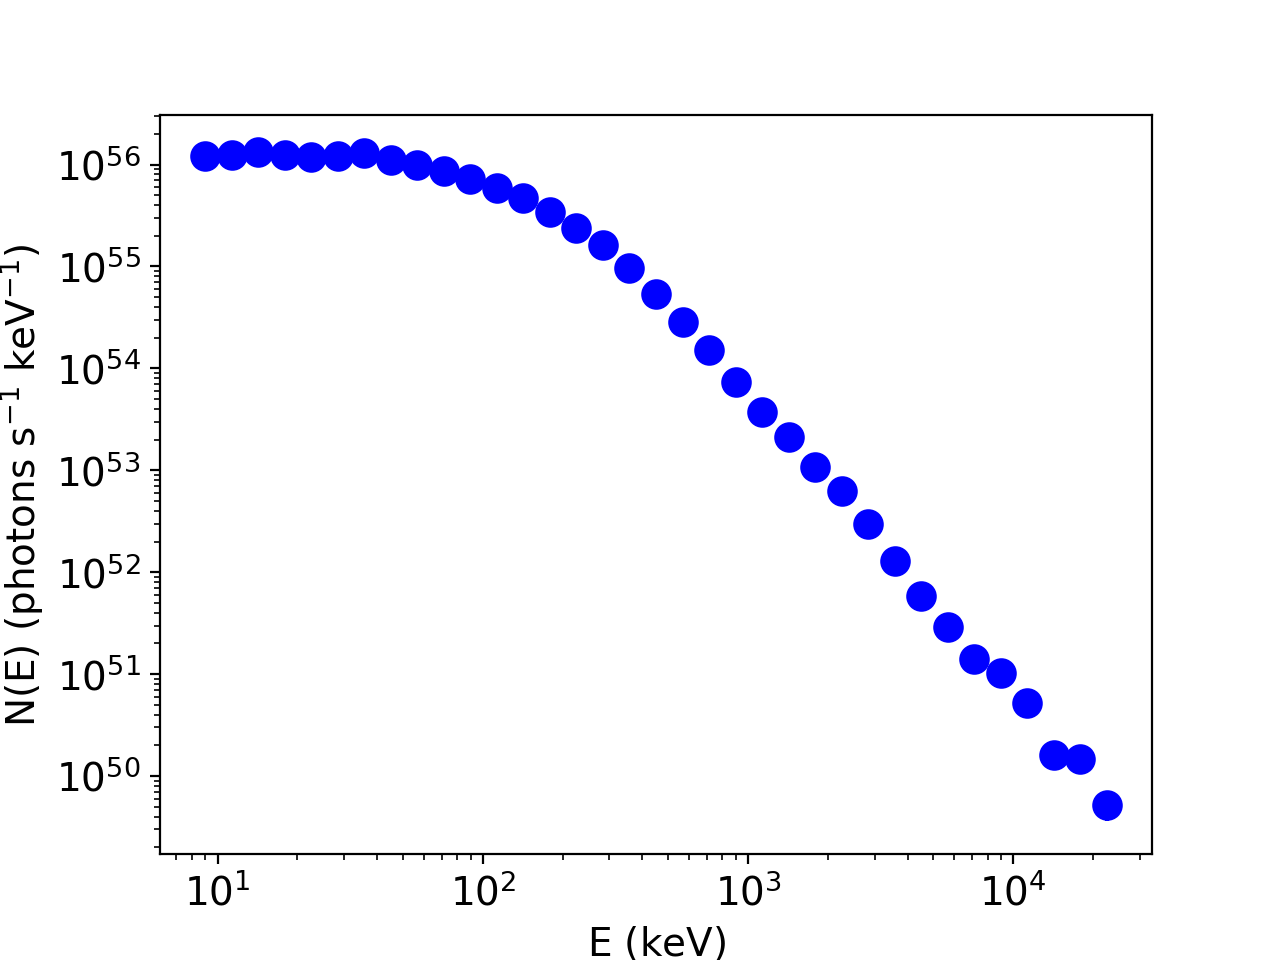

-0.12886258983031731


In [44]:
pm.plot_spectrum(inst_spec_dict); #if the figure is a bit small with the labels cutoff, you can drag the bottom right \
                                #  corner of the plot to make it larger
plt.pause(1)
print(inst_spec_dict['fit']['alpha'])

We can see that the spectrum was indeed calculated within the limits that we had specified and the figure has the correct units that we specified for the calculations already. Lets also look at the best fit function and assess its fit:

<IPython.core.display.Javascript object>


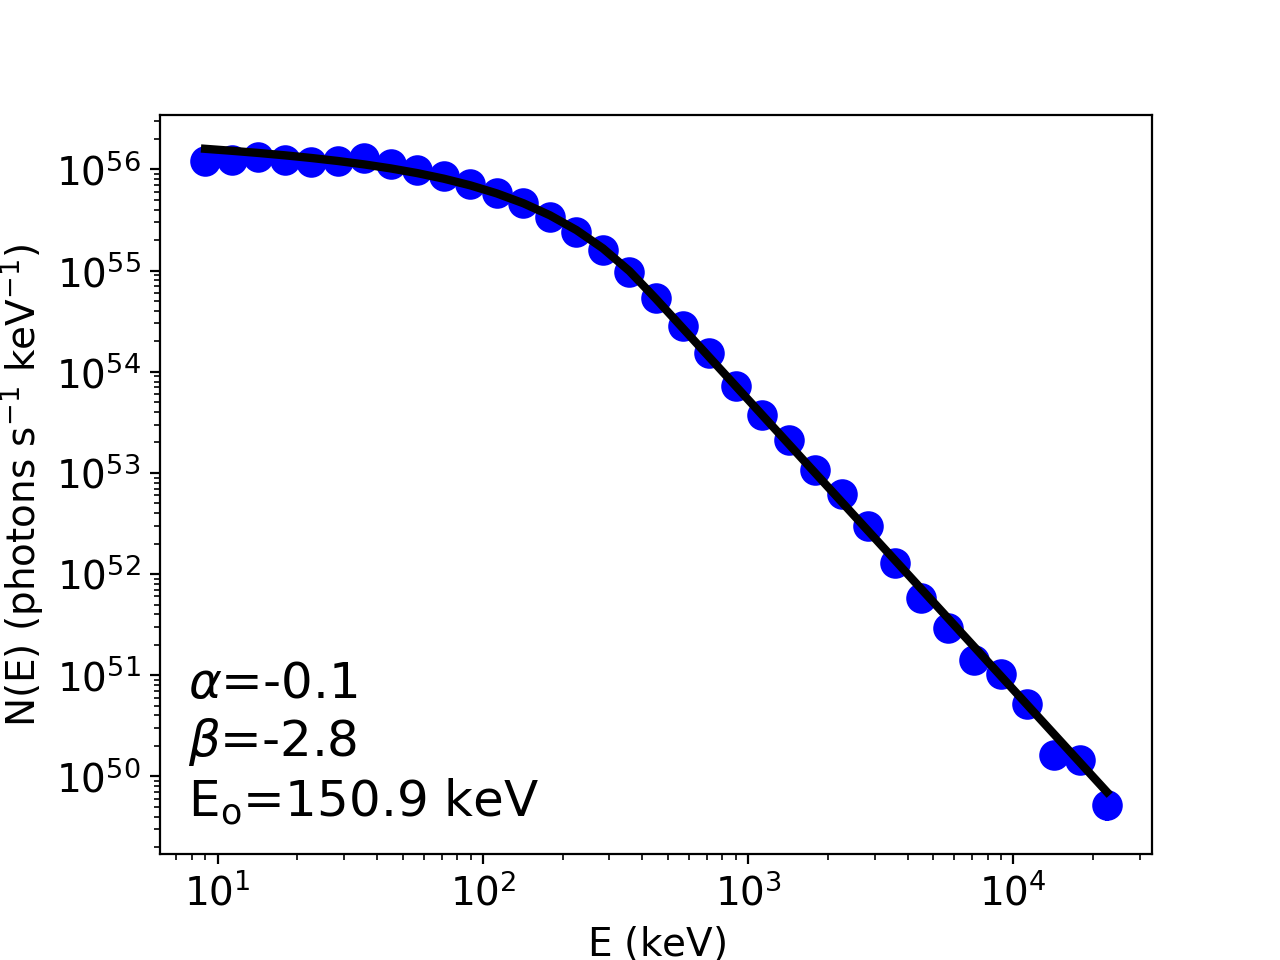

In [45]:
pm.plot_spectrum(inst_spec_dict, plot_fit=True);
plt.pause(1)

Lets look at the entire time integrated spectrum in erg/s/keV that we calculated much earlier with polarization:

<IPython.core.display.Javascript object>


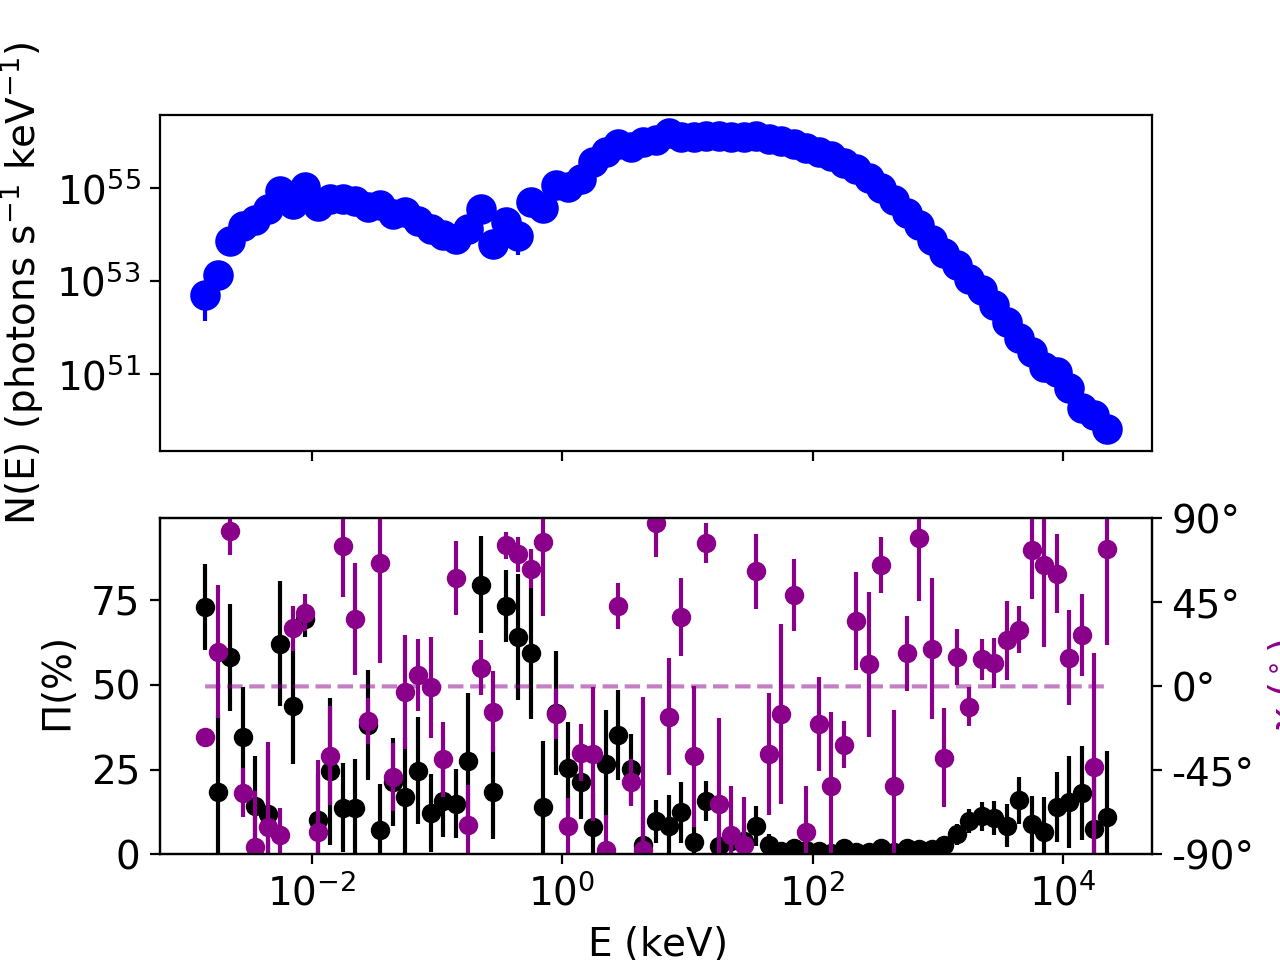

In [46]:
fig, axes=pm.plot_spectrum(spectrum_dict, plot_polarization=True);
plt.pause(1)

The returned values are handles to the figure and the axes of the plot which allows you to modify the plot to your liking. Lets take our fitted spectrum and change the hard-to-see black line to something more visible:

<IPython.core.display.Javascript object>


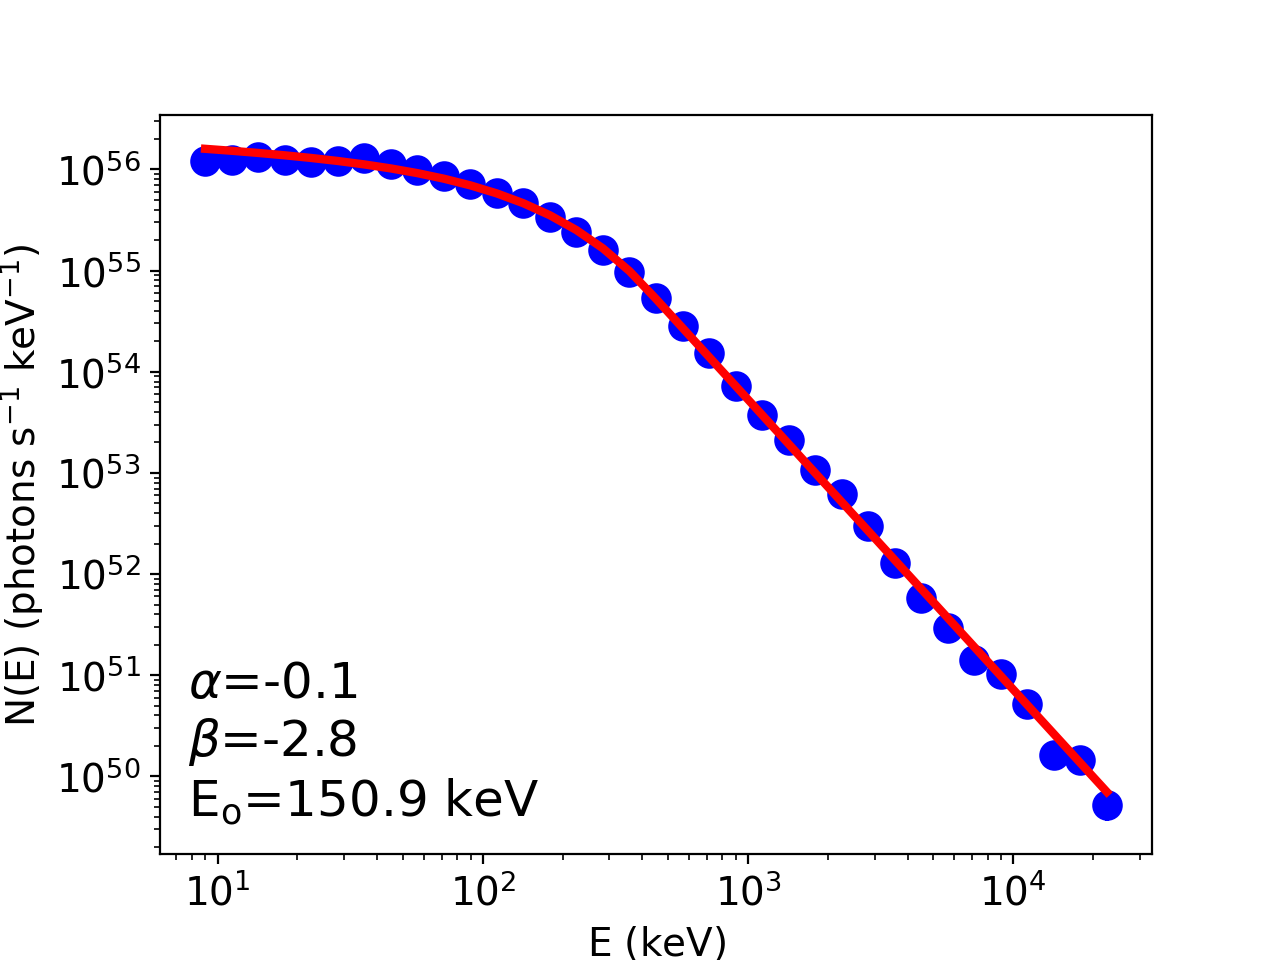

In [47]:
fig, axes=pm.plot_spectrum(inst_spec_dict, plot_fit=True)
lines=axes.get_lines()
lines[2].set_color('r')
fig.canvas.draw()
plt.pause(1)

There is one other keyword that can be passed to the `plot_spectrum` function. This is the `photon_num_min` keyword and it tells the function to plot the points that had at least $n$ photons in the energy bin. The default value for $n$ is 10, which also correponds to the default value of the number of photons needed to assume that a spectral bin had gaussian errors to conduct the fitting when we called the `set_spectral_fit_parameters` method.

All quantities can be plotted simply by setting each to `True` such as:

<IPython.core.display.Javascript object>


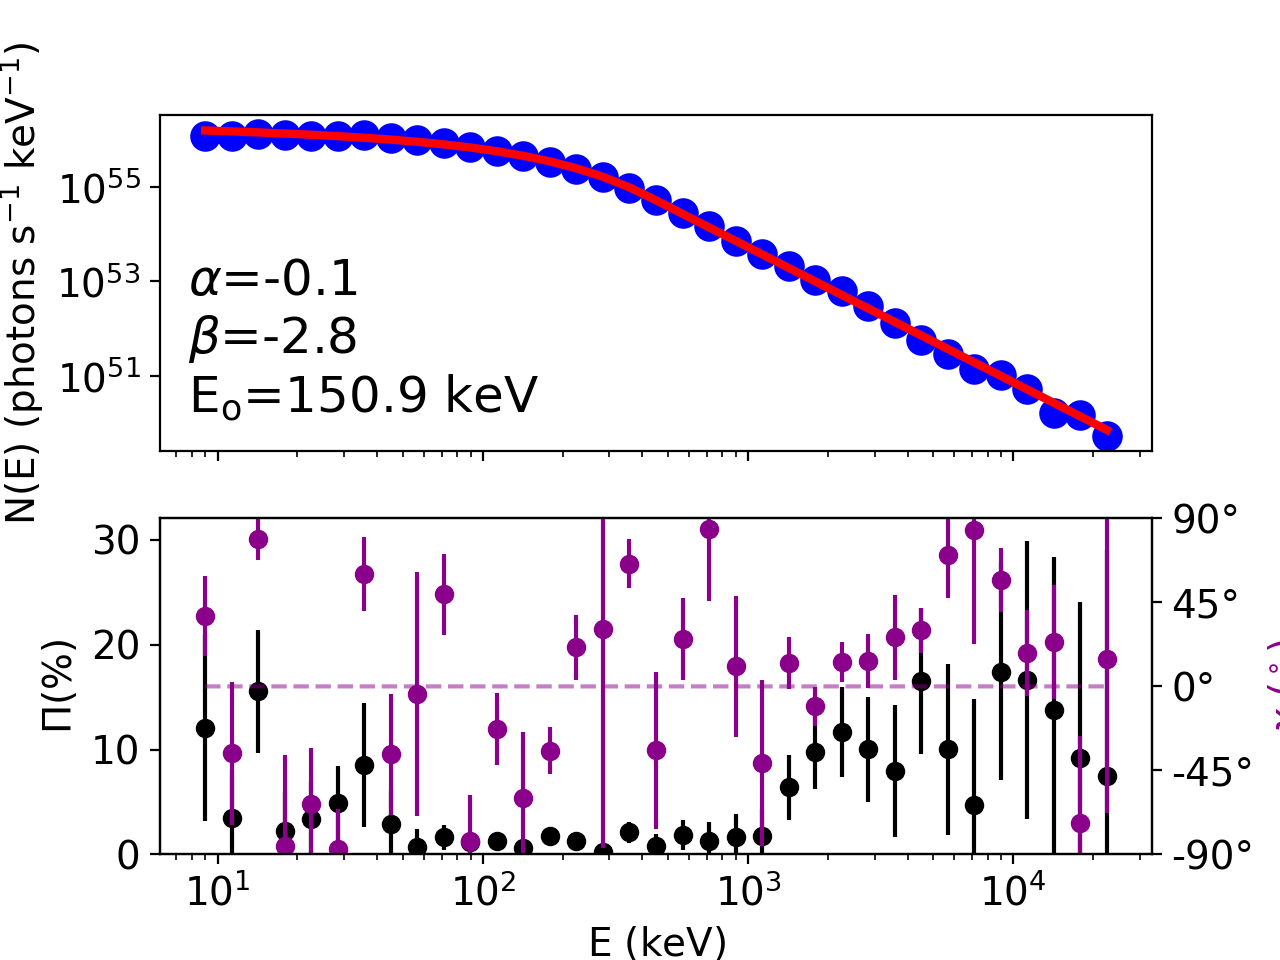

In [48]:
fig, axes=pm.plot_spectrum(inst_spec_dict, plot_fit=True, plot_polarization=True)
lines=axes[0].get_lines()
lines[2].set_color('r')
plt.pause(1)

Now we can explore the `plot_lightcurve` function which can plot multiple light curves at the same time, when passed in as a list, and also simultaneously plot the polarization and time resolved spectral fitted parameters for the first light curve in the list that is passed in.

We can plot our light curve with polarization and the spectral fitted parameters by doing:

<IPython.core.display.Javascript object>


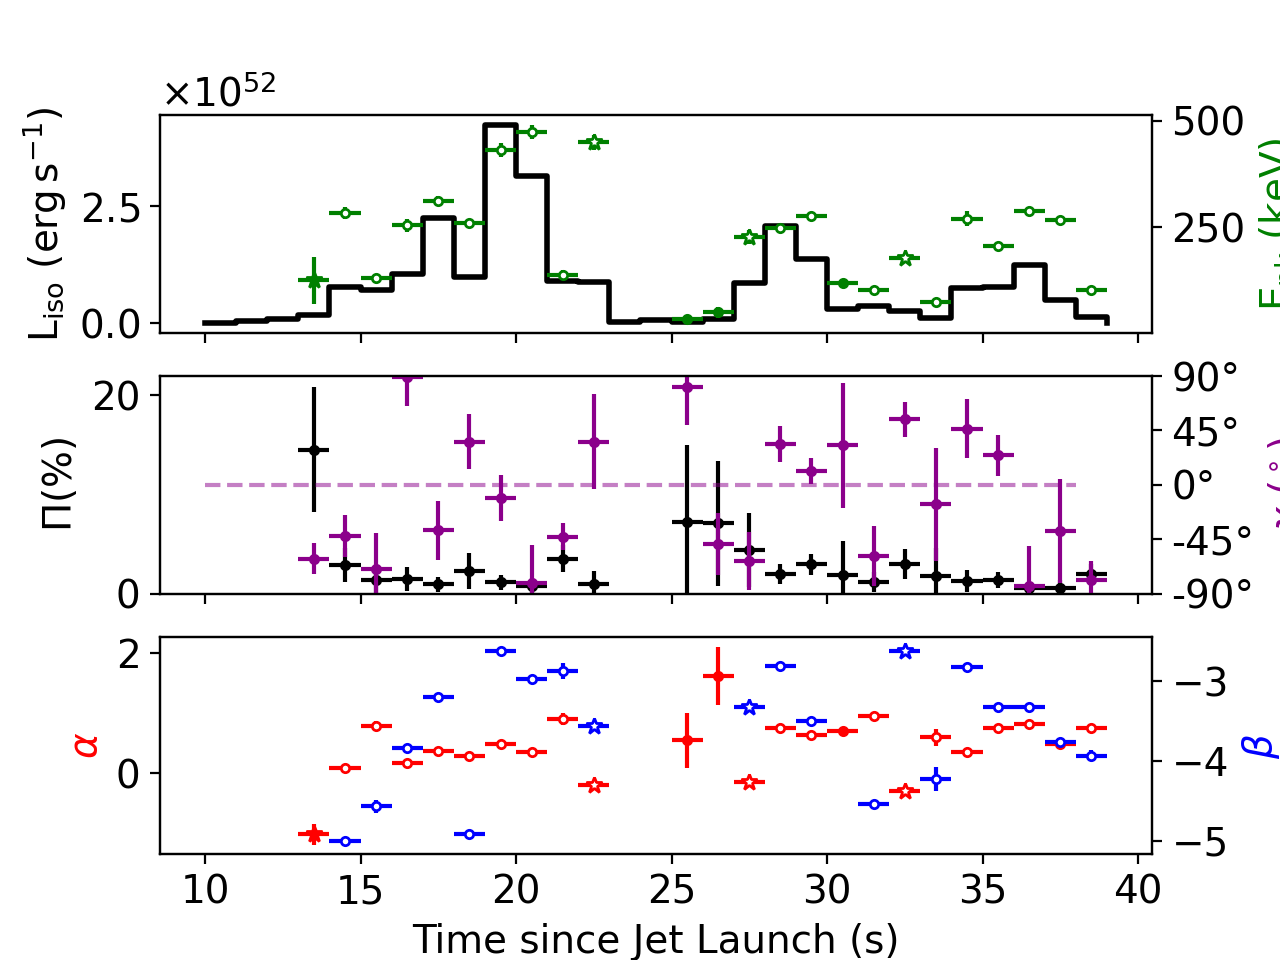

{'lightcurve': <Quantity [2.92091596e+41, 3.85639401e+50, 8.61509309e+50, 1.60961363e+51,
           7.74870932e+51, 7.09771519e+51, 1.03939932e+52, 2.24516989e+52,
           9.77912473e+51, 4.23675448e+52, 3.14942746e+52, 8.94048284e+51,
           8.69349477e+51, 6.95844251e+49, 4.80861644e+50, 2.23066145e+50,
           7.94259148e+50, 8.46893872e+51, 2.06994765e+52, 1.36243752e+52,
           3.03451783e+51, 3.65369598e+51, 2.58714005e+51, 1.03679305e+51,
           7.46551565e+51, 7.59923316e+51, 1.22742700e+52, 4.92113568e+51,
           1.12690222e+51, 0.00000000e+00] erg / s>, 'lightcurve_errors': <Quantity [6.87975173e+40, 1.63252416e+50, 1.42613220e+50, 1.46640995e+50,
           1.91526452e+50, 1.37230519e+50, 1.74572780e+50, 2.49473139e+50,
           2.52877780e+50, 4.48290077e+50, 3.65483423e+50, 1.71694285e+50,
           1.58214843e+50, 6.29942221e+48, 1.14531976e+50, 2.46235102e+49,
           7.06626986e+49, 4.45427747e+50, 2.98054829e+50, 2.10611882e+50,
           

In [49]:
pm.plot_lightcurve([lightcurve_dict], plot_polarization=True, plot_spectral_params=True);
plt.pause(1)
print(lightcurve_dict)

If we have multiple light curves that we want to plot then the first light curve with its fitted spectral parameters and calculated polarizations are passed. These light curves are then all normalized to their maximal values L$_\mathrm{max}$. 

Like the `plot_spectrum` function, the `plot_lightcurve` function outputs the figure and axes object arrays that allow you to make modifications to the plot as you would like.

With a number of spectra, you can also produce histograms of the best fit spectral parameters using the `plot_spectral_fit_hist` function. It takes a list of light curve observations where time resolved spectral fitting has been done and it plots the corresponding histograms. This function can also take a dataset of observational spectral parameters such as what is given by the `get_FERMI_best_data` function. In order to plot these histograms we would do:

<IPython.core.display.Javascript object>


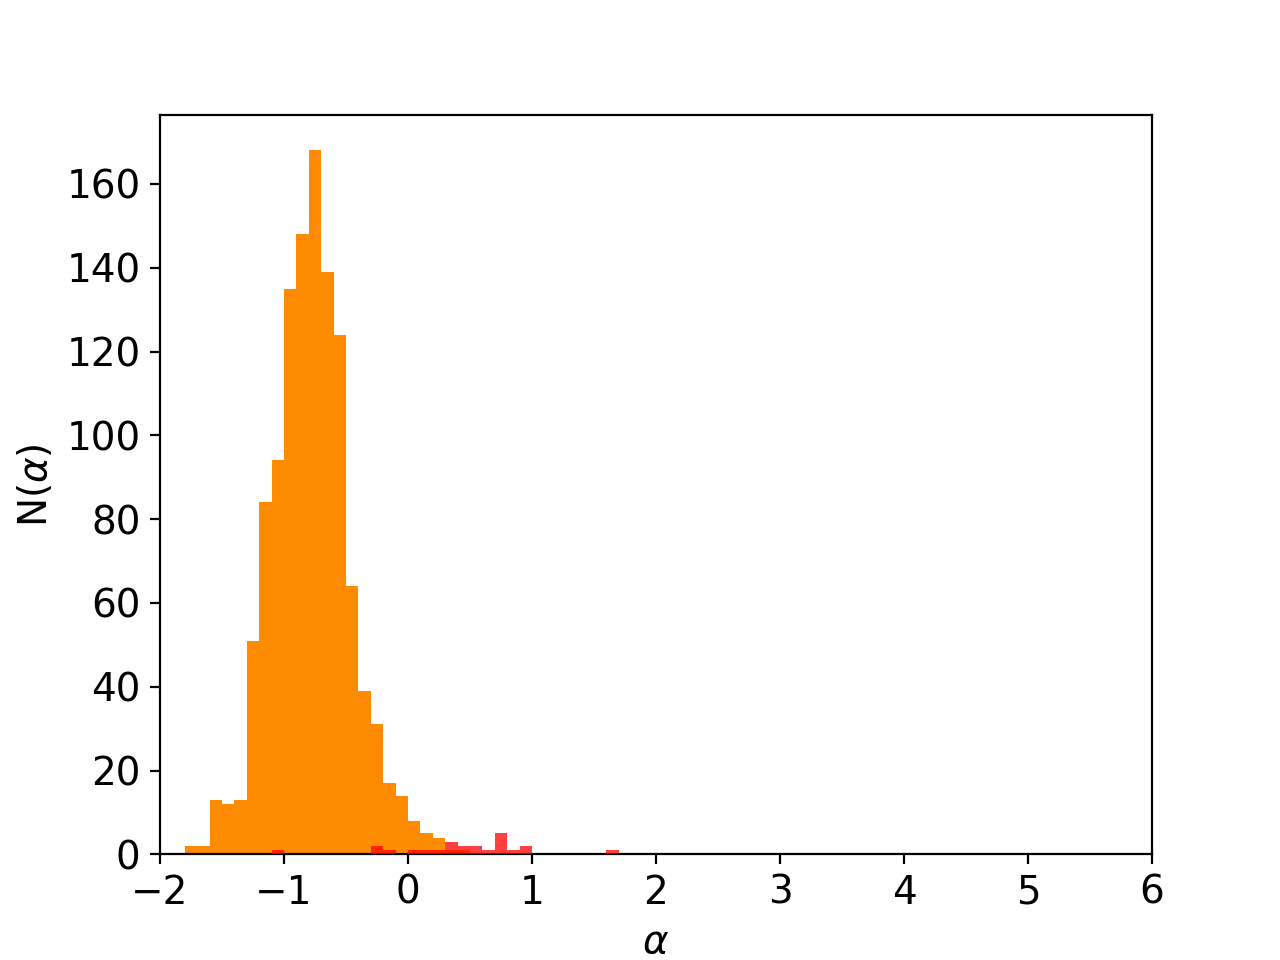

<IPython.core.display.Javascript object>


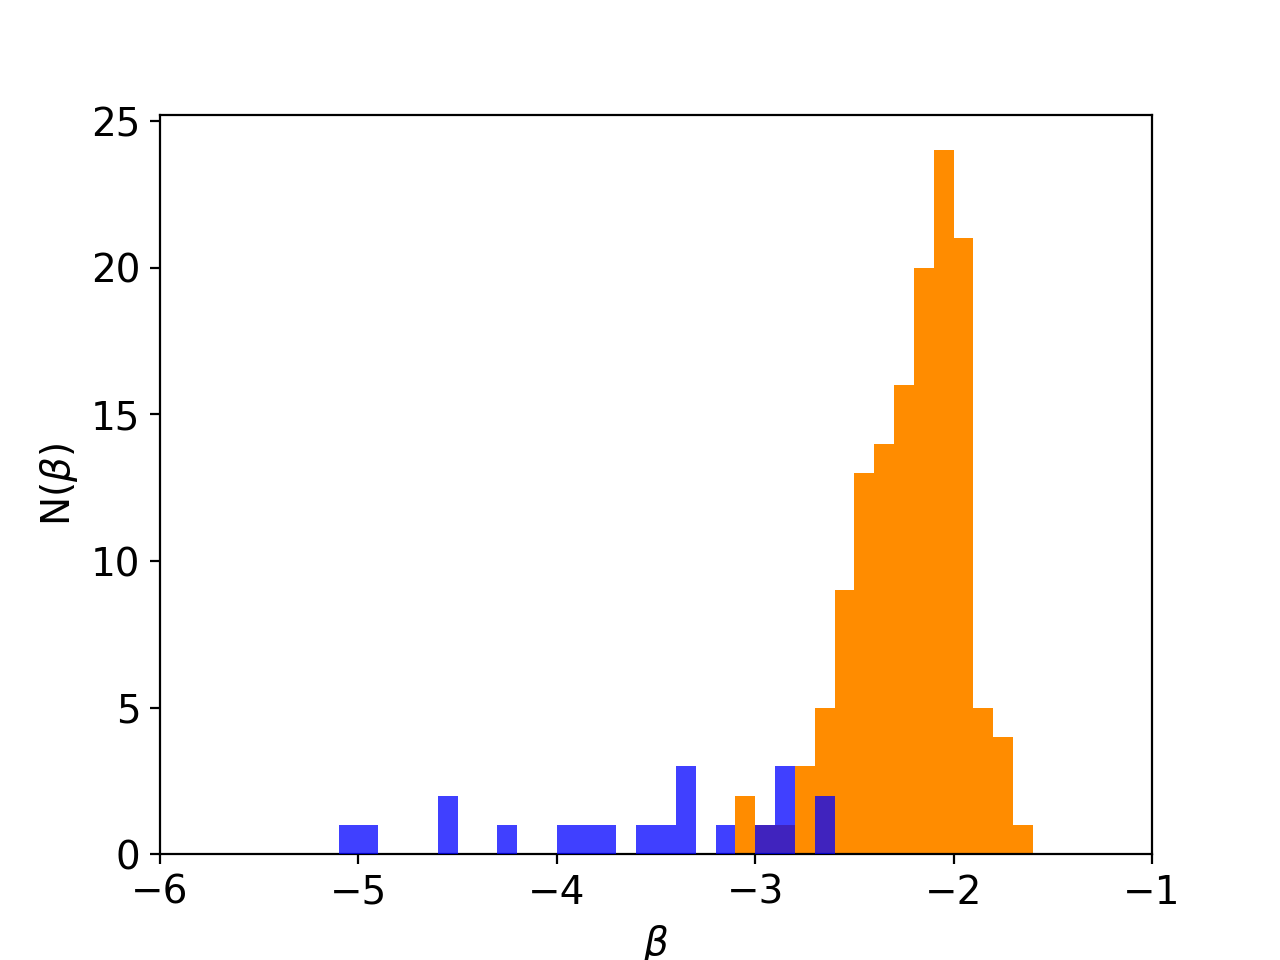

<IPython.core.display.Javascript object>


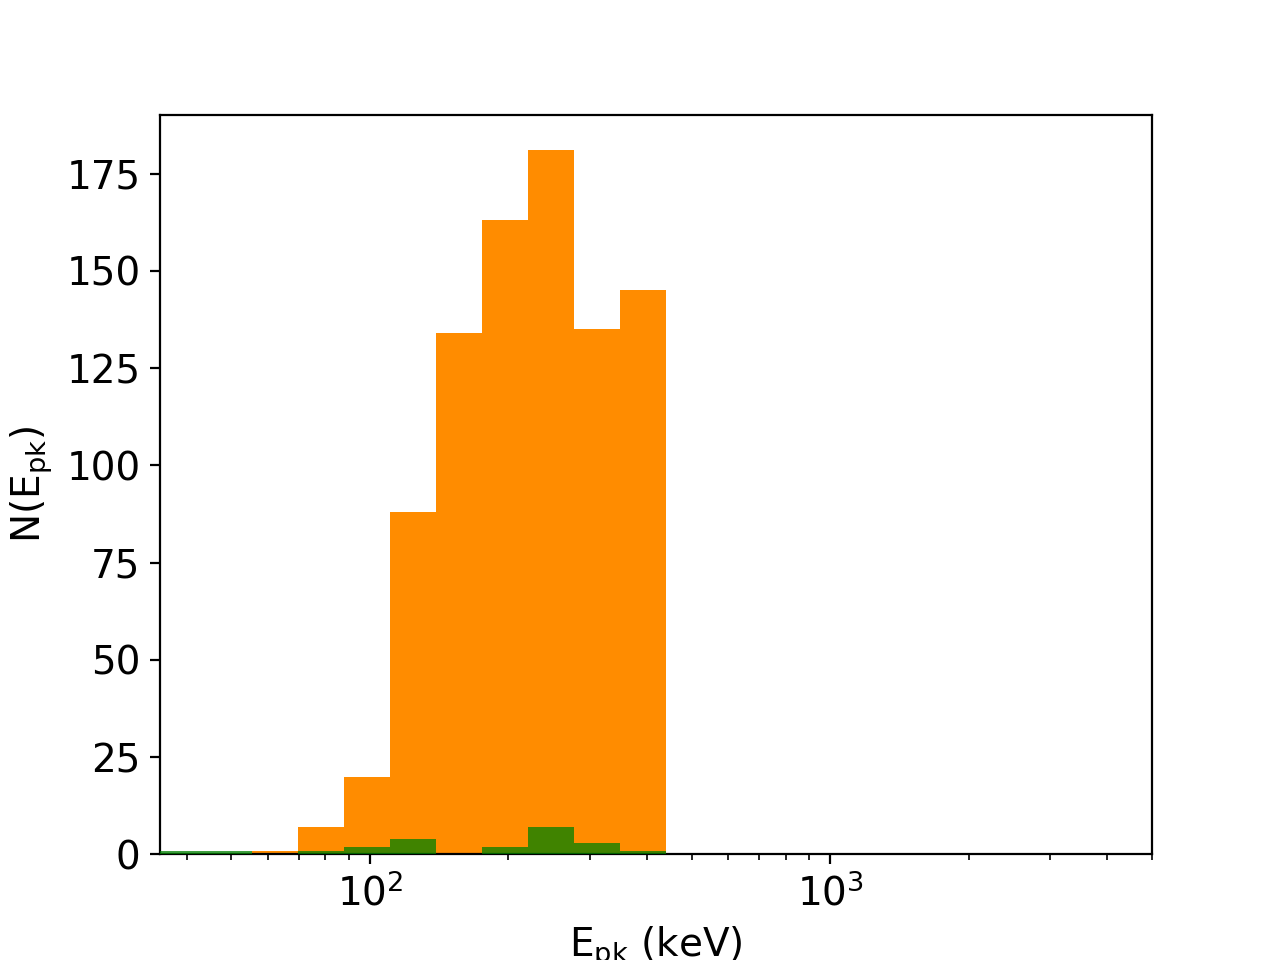

In [50]:
pm.plot_spectral_fit_hist([lightcurve_dict], observational_data=pm.get_FERMI_best_data());
plt.pause(1)

This function returns the array of figures and axes that allow you to modify each plot to your liking. Additionally, it returns arrays of all the fitted spectral parameters.

The ProcessMCRaT library makes it easy to analyze data for a number of observer viewing angles, wavelenghts, or any thing else that you are interested in. It is easy to make a list of MockObservation objects that you can then do a number of analyses on. For example, we may want to compare our MCRaT simulation to a number of observational relationships. Lets do this for the Yonetoku, Golenetskii, and Amati relationships.

First we create a list of observations for observers at different viewing angles:

In [51]:
observation_list=[]
for i in range(1,10): 
    observation_list.append(pm.MockObservation(i, 1, 1e13, 10, mcratsimload_obj=mcrat_sim))

Now we make our lists of mock observations for the spectra, polarizations, and light curves:

In [52]:
spec_dict_list=[];lc_dict_list=[];pol_dict_list=[]  
for i in observation_list: 
    i.set_spectral_fit_parameters()  
    spec_dict_list.append(i.spectrum(0, 45,spectrum_unit=unit.count/unit.s/unit.keV , fit_spectrum=True)) 
    lc_dict_list.append(i.lightcurve(time_start=10, time_end=40, dt=1) ) #dt=1 here for plotting the Yonetoku relation
    pol_dict_list.append(i.polarization(0, 45)) 

Now we can plot the mock observations along the Yonetoku, Golenetskii, and Amati relationships using the `plot_yonetoku_relationship`, `plot_golenetskii_relationship`, and `plot_amati_relationship` functions. Each function returns the figure, axes, and either the colorbar or line objects that are in the plot so the user can customize their plot as needed.

<IPython.core.display.Javascript object>


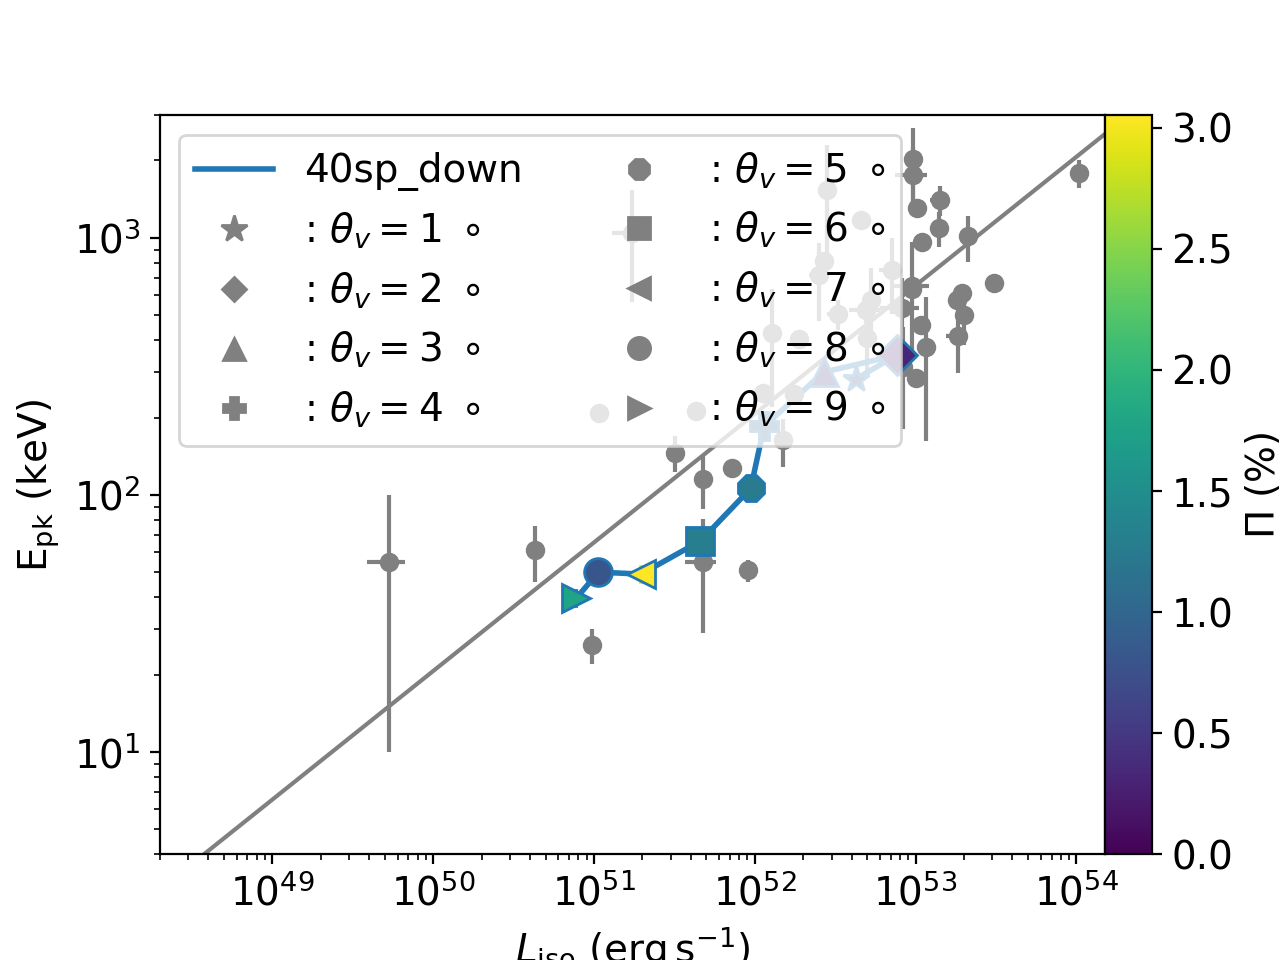

In [53]:
pm.plot_yonetoku_relationship(spec_dict_list, lc_dict_list, plot_polarization=True, polarization_list=pol_dict_list,\
                              labels=[r'40sp_down']); #make sure that the light curves are binned into 1 s bins
plt.pause(1)

In the Yonetoku case we are able to plot the results of the *40sp_down* simulation for a number of different viewing angles with bolometric polarization alongside the yonetoku relationship which we have acquired from the `get_yonetoku_relationship` function, and some observational GRB data. The polarization parameters and label parameters are optional. If we leave them off, we get:

<IPython.core.display.Javascript object>


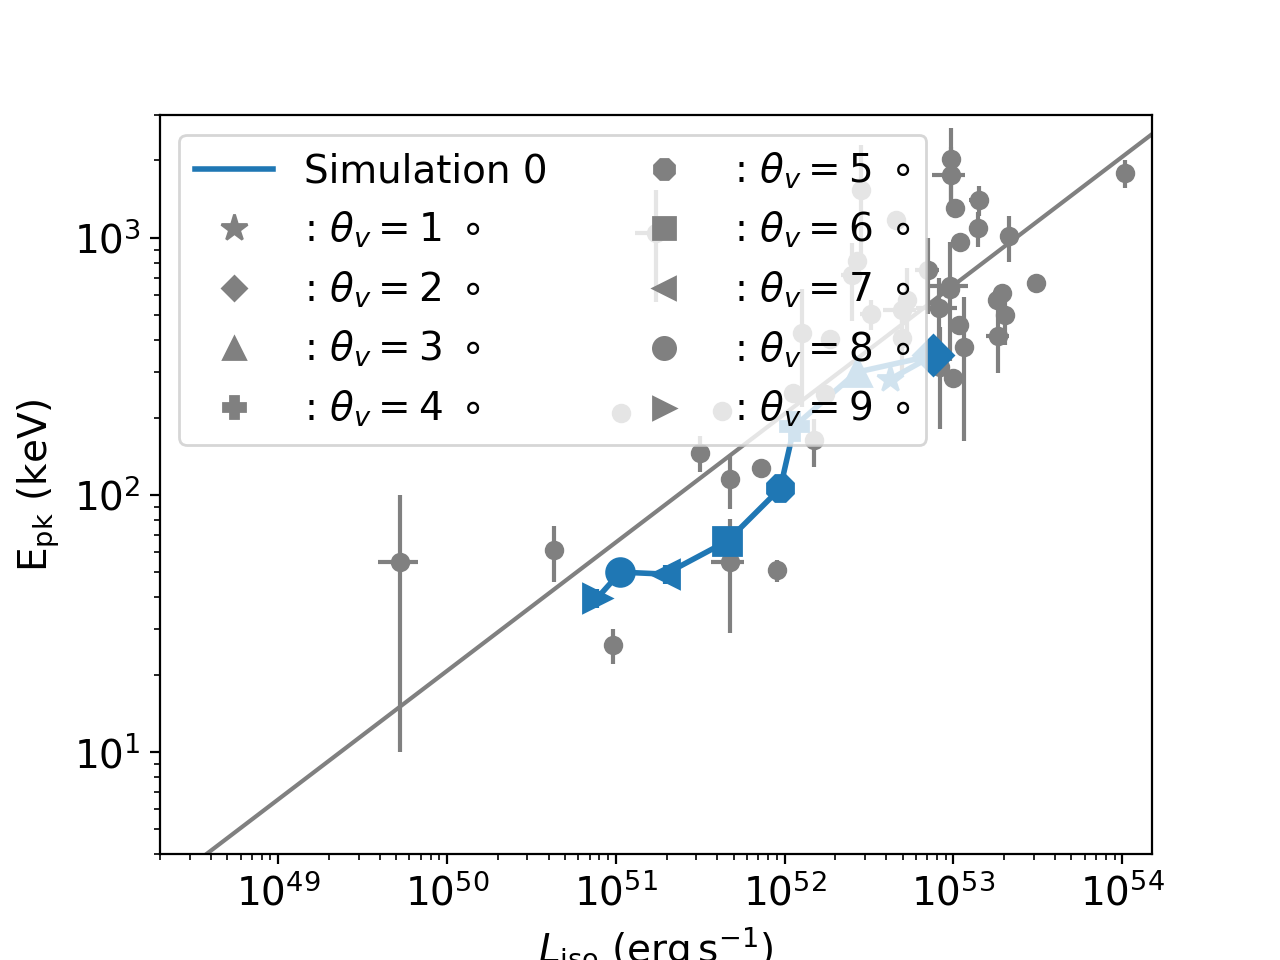

In [54]:
pm.plot_yonetoku_relationship(spec_dict_list, lc_dict_list);#make sure that the light curves are binned into 1 s bins
plt.pause(1)

We can pass in a list of lists, where each individual list corresponds to a different simulation and the number of elements in the list correspond to the various observer viewing angles. In this case, the number of labels corresponds to the number of sub-lists that are in the main list that is passed to the function. For example we can have a list of 2 sublists, one sublist is the *40sp_down* results for observers located from 1-9$^\circ$ while the second sublist could be for another simulation (e.g our *16TI* simulation) for observers located from 1-15$^\circ$.

The function also takes an input function that defined the Yonetoku relationship itself, with no passed parameters, the upper limit, when '+' is passed to it, and the lower limit, when '-' is passed, similar to the formatting of the `get_yonetoku_relationship` function.

To plot the Golenetskii relationship we would do:

<IPython.core.display.Javascript object>


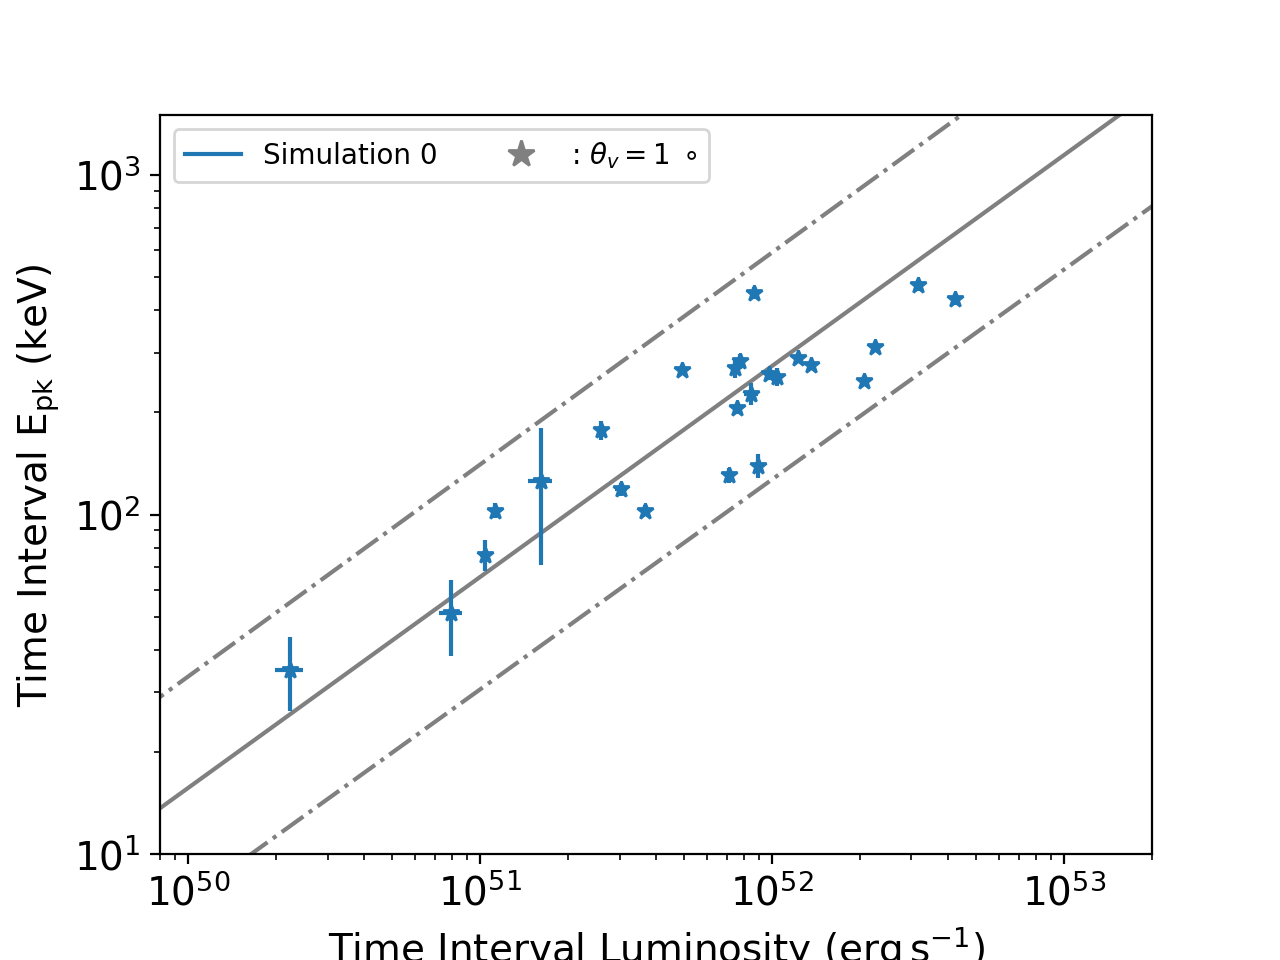

In [55]:
pm.plot_golenetskii_relationship(lightcurve_dict, luminosity_cutoff=1e50);
plt.pause(1)

Where we can pass a list of light curve dictionaries that correspond to various observer viewing angles for a given MCRaT simulation. We can also pass in a label for the simulation, a function that defines the golenetskii realtionship and its upper and lower limits, and a luminosity cutoff that may coincide with observational analyses. In the case of the function that defines the golenetskii relationship, it should be formatted the same as the `get_golenetskii_relationship` which takes no argument to return the relationship itself, but takes the `+` argument to return some upper limit, and a `-` argument to return a lower limit on the relationship. 

In [56]:
pm.get_golenetskii_relationship?

To plot the Amati relationship we would do:

<IPython.core.display.Javascript object>


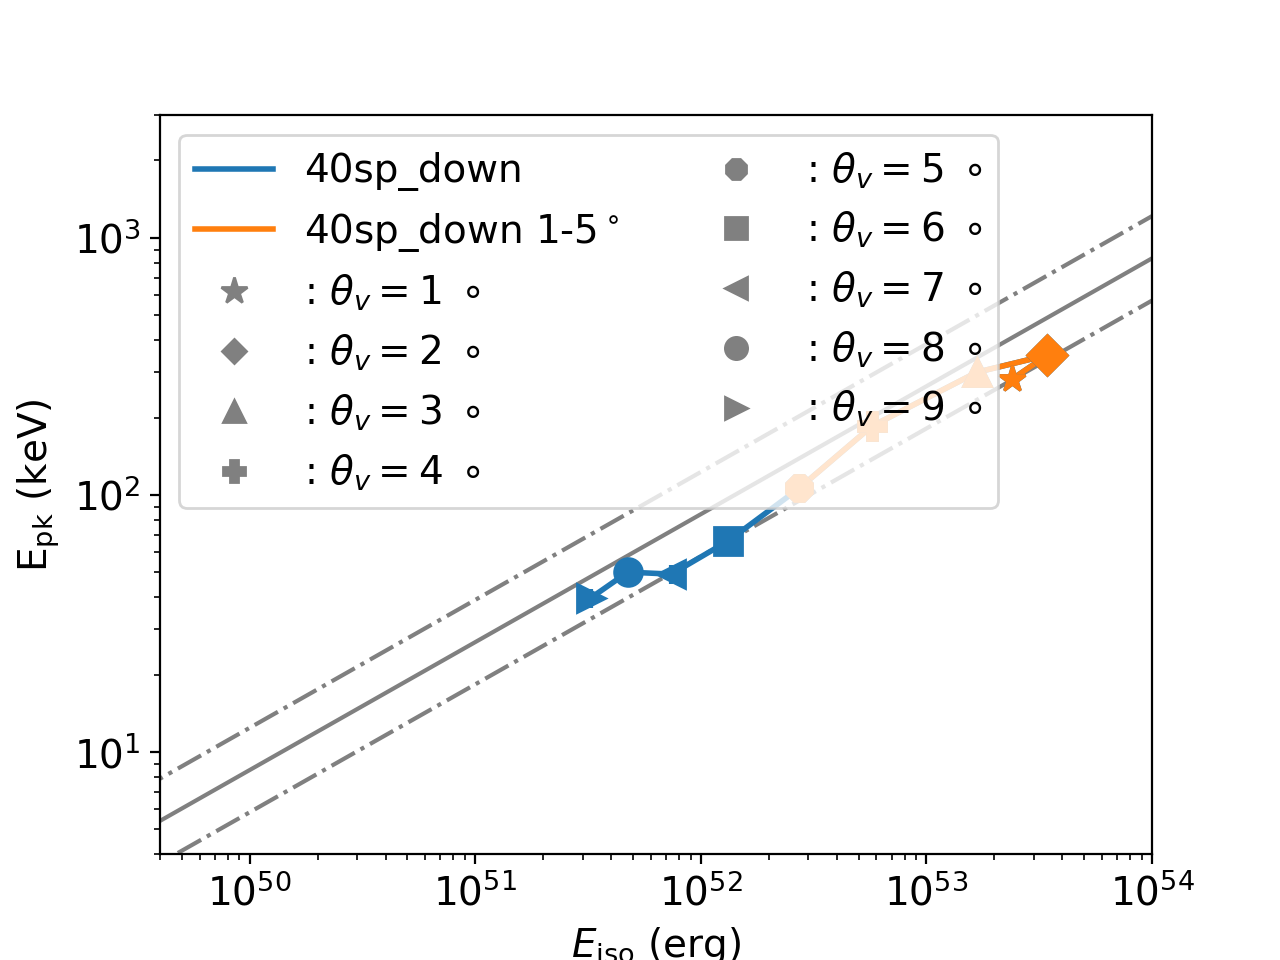

In [57]:
pm.plot_amati_relationship([spec_dict_list, spec_dict_list[:5]], [lc_dict_list, lc_dict_list[:5]],\
                           labels=['40sp_down', r'40sp_down 1-5$^\circ$']); 
plt.pause(1)

Where we have plotted the *40sp_down* simulation and created a 'different' simulation defined as the first 5 viewing angles of the *40sp_down* simulation. This allows us to show the fact that the `plot_amati_relationship` function has the same functionality as the `plot_yonetoku_relationship` where it can plot points from various simulation sets based on its inputs being lists of lists.

The `plot_amati_relationship` can also be passed a function that defines the upper and lower limits of the reationship similar to the `get_amati_relationship` function that is included in ProcessMCRaT.

In [58]:
pm.get_amati_relationship?

In addition to these plots that allow us to explore how well the MCRaT simulations reproduce observational relationships relating spectral energies and the light curves, we can explore the polarization properties as well.

We can plot the polarization degree and angle as a function of $\theta_\mathrm{v}$ with: 

<IPython.core.display.Javascript object>


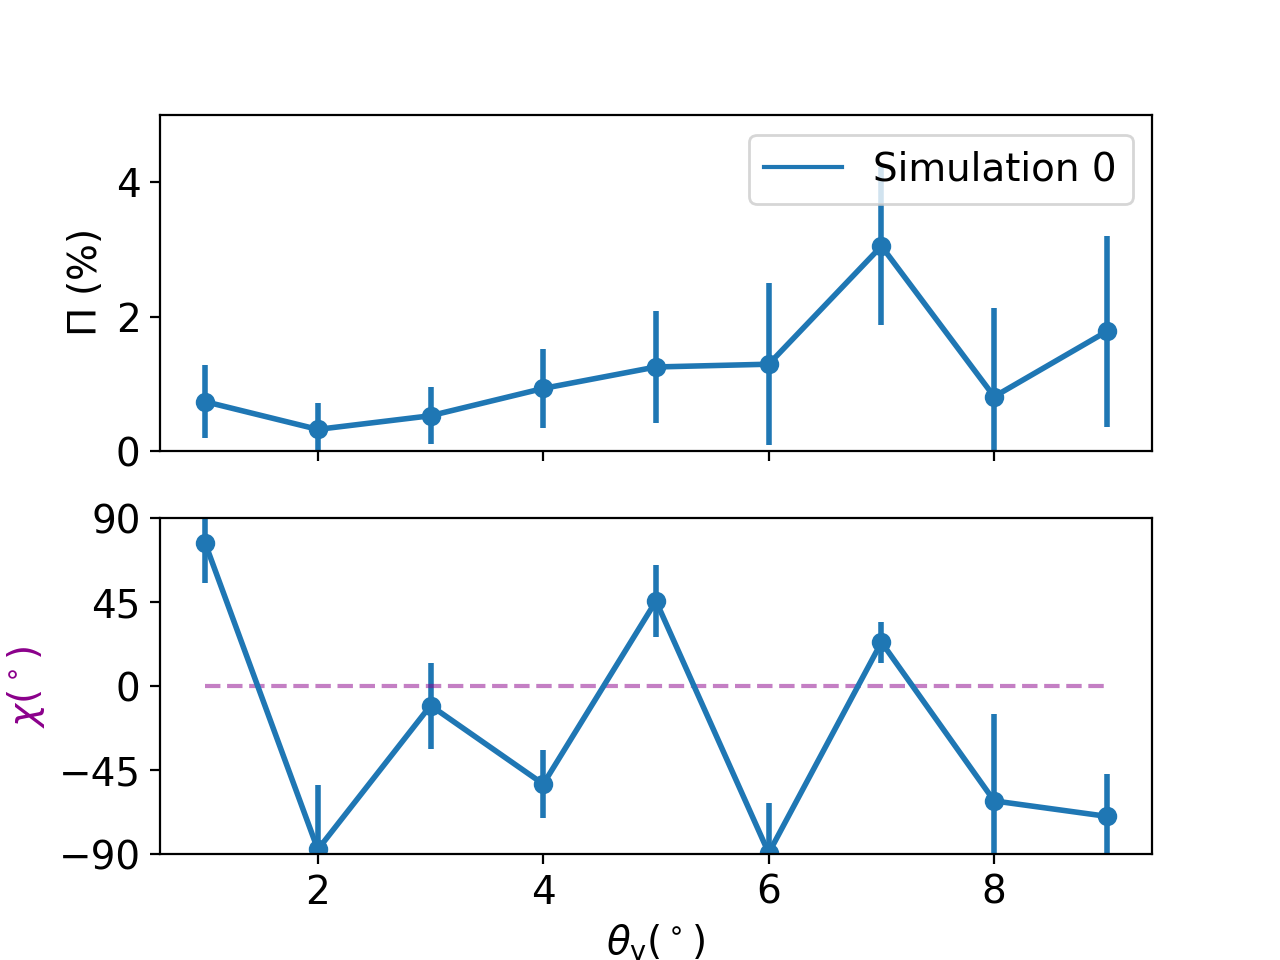

In [59]:
pm.plot_polarization_observer_angle(pol_dict_list, plot_pol_angle=True); 
plt.pause(1)

And like some of the previous functions that we have covered, the `plot_polarization_observer_angle` can plot multiple simulations at the same time by passing it a list of sublists for each MCRaT simulation. This can look like:

<IPython.core.display.Javascript object>


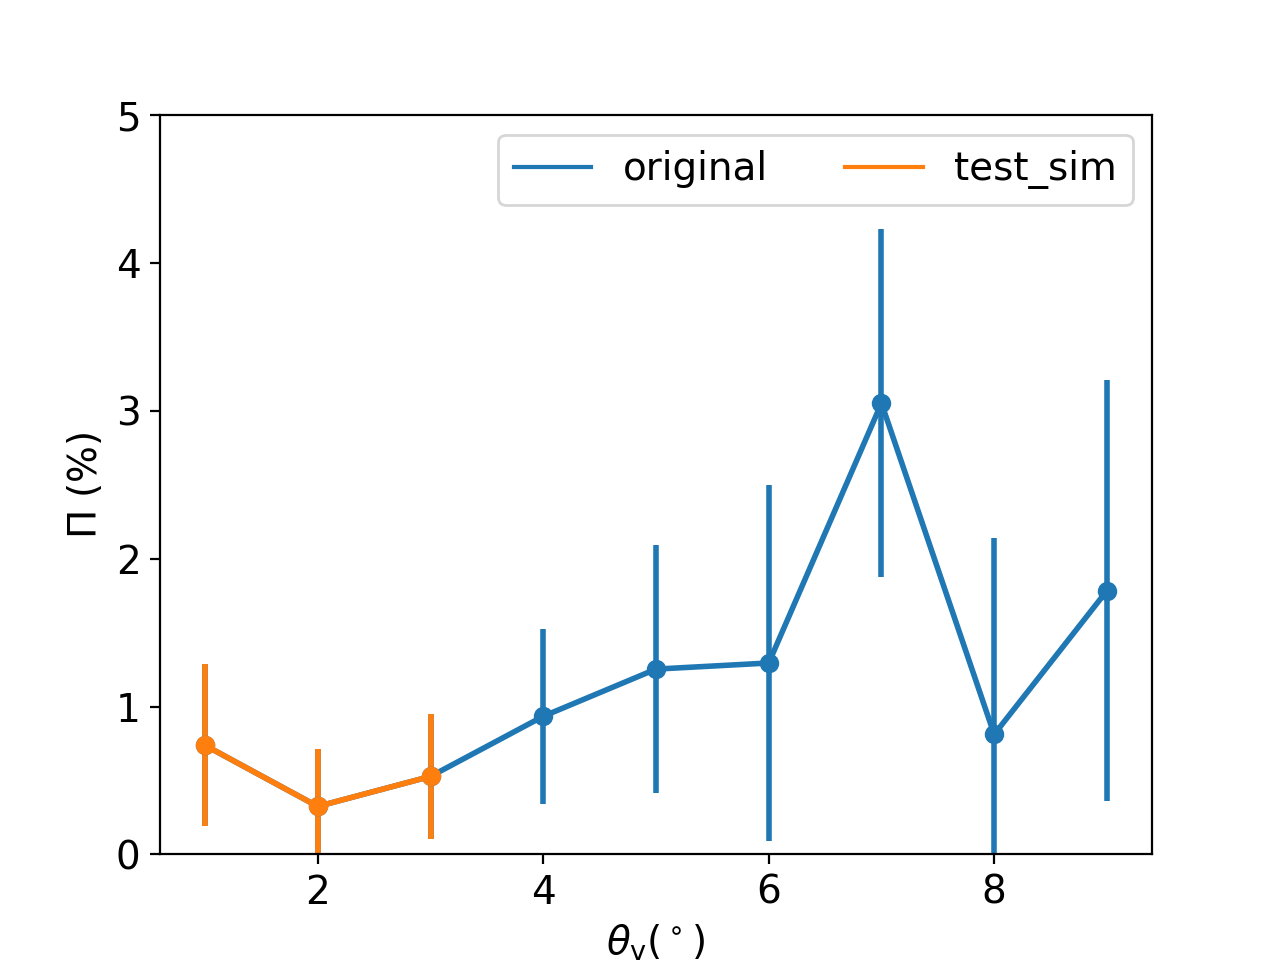

In [60]:
pm.plot_polarization_observer_angle([pol_dict_list, pol_dict_list[:3]], labels=['original', 'test_sim']);
plt.pause(1)

We can also plot the polarization as a function of the spectral peak energy using:

<IPython.core.display.Javascript object>


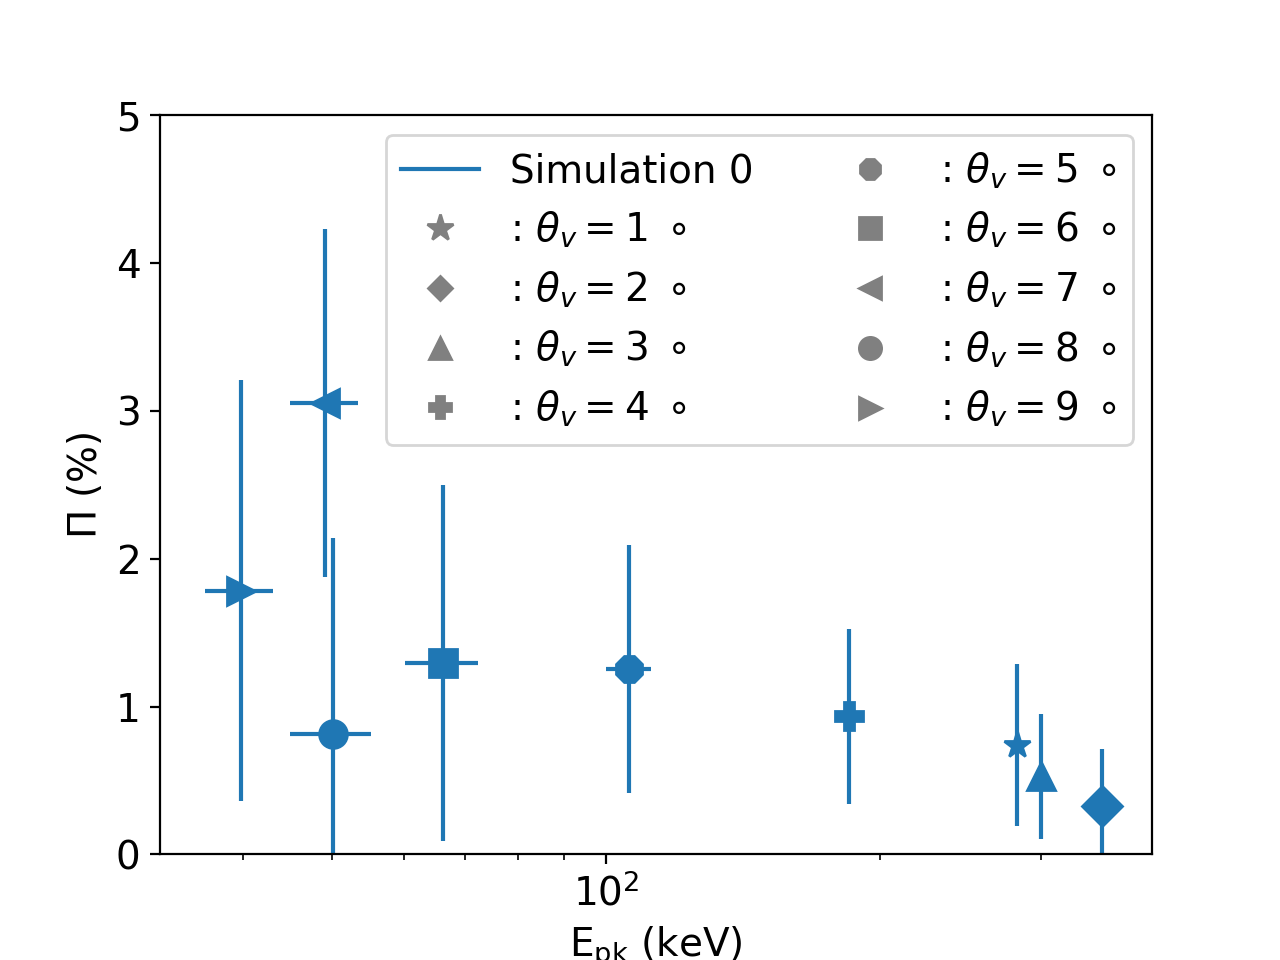

In [61]:
pm.plot_polarization_peak_energy(spec_dict_list, pol_dict_list); 
plt.pause(1)

With these plots we can also add our own observational points to compare to. For example, lets calculate the optical polarization within the Swift white band and compare it to an observation made by [Troja et. al.](https://www.nature.com/articles/nature23289) where they measured a GRB's lower limit optical polarization to be 8% and its spectral peak energy to be 140 keV.

To save memory we will delete some variables. In the following line, we summarize some of the important points of using the ProcessMCRaT package to analyze MCRaT data and produce the optical polarization comparison.

In [62]:
del inst_spec_dict, lightcurve_dict, spect_count_dict, spectrum_dict, time_int_pol, t, mcrat_sim

In [63]:
mcrat_sim=pm.McratSimLoad() 
mcrat_sim.load_frame(1999, read_stokes=True)

#create the instrument that we need 
inst=pm.Instrument(name='Swift_white',polarization_energy_range=[1597,7820]*unit.angstrom) 

#create our observations for each observer viewing angle
observation_list=[]
for i in range(1,10): 
    observation_list.append(pm.MockObservation(i, 1, 1e13, 10, mcratsimload_obj=mcrat_sim))
    
#load the instrument and specify the spectral fitting parameters to make the calculations
spec_dict_list=[];pol_dict_list=[]  
for i in observation_list: 
    i.load_instrument(inst)
    i.set_spectral_fit_parameters()  
    spec_dict_list.append(i.spectrum(0, 45,spectrum_unit=unit.count/unit.s/unit.keV , fit_spectrum=True)) 
    pol_dict_list.append(i.polarization(0, 45)) 

<IPython.core.display.Javascript object>


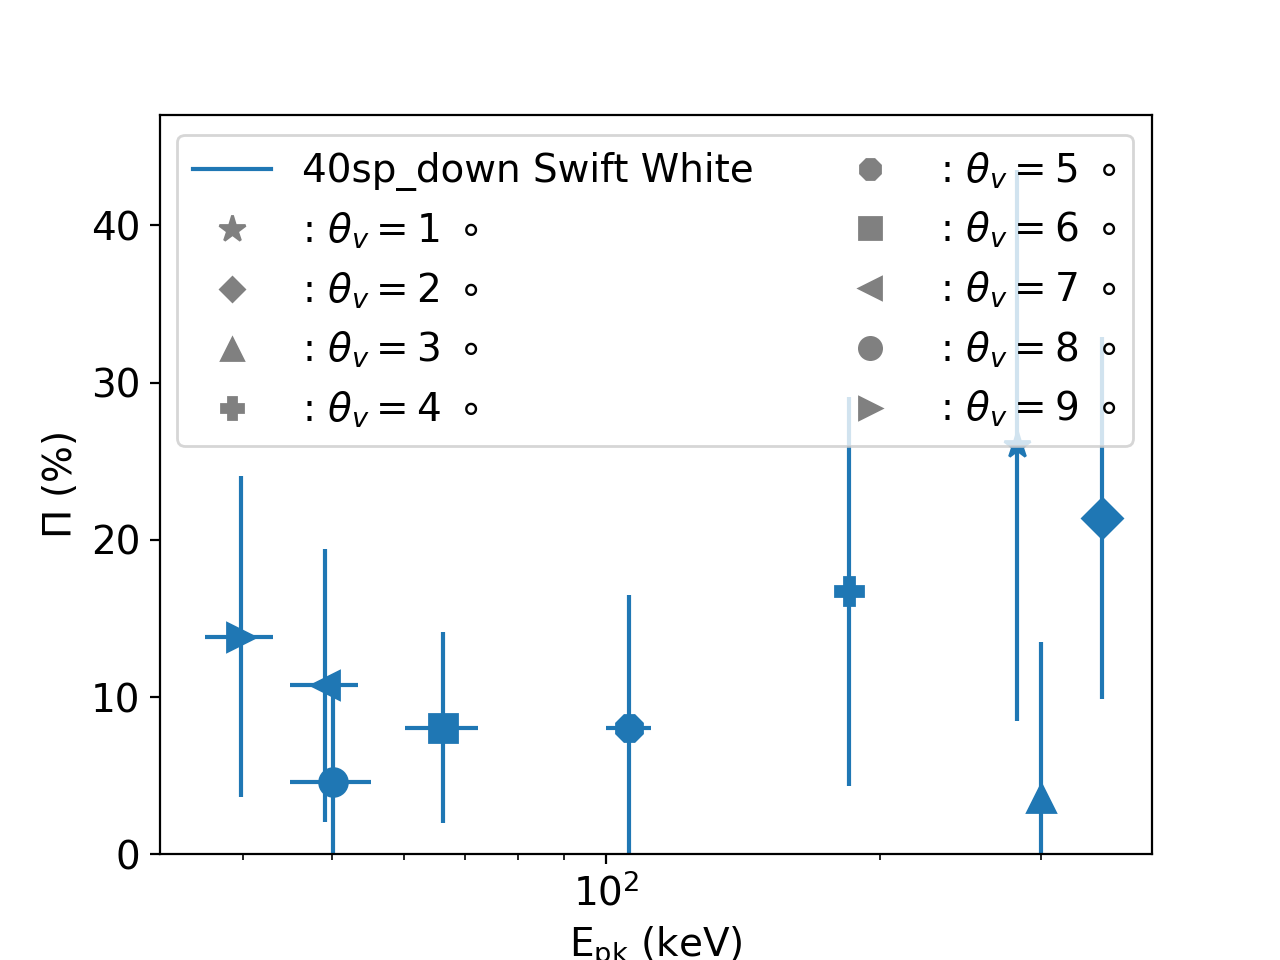

In [64]:
fig, ax=pm.plot_polarization_peak_energy(spec_dict_list, pol_dict_list, labels=['40sp_down Swift White']) 

<IPython.core.display.Javascript object>


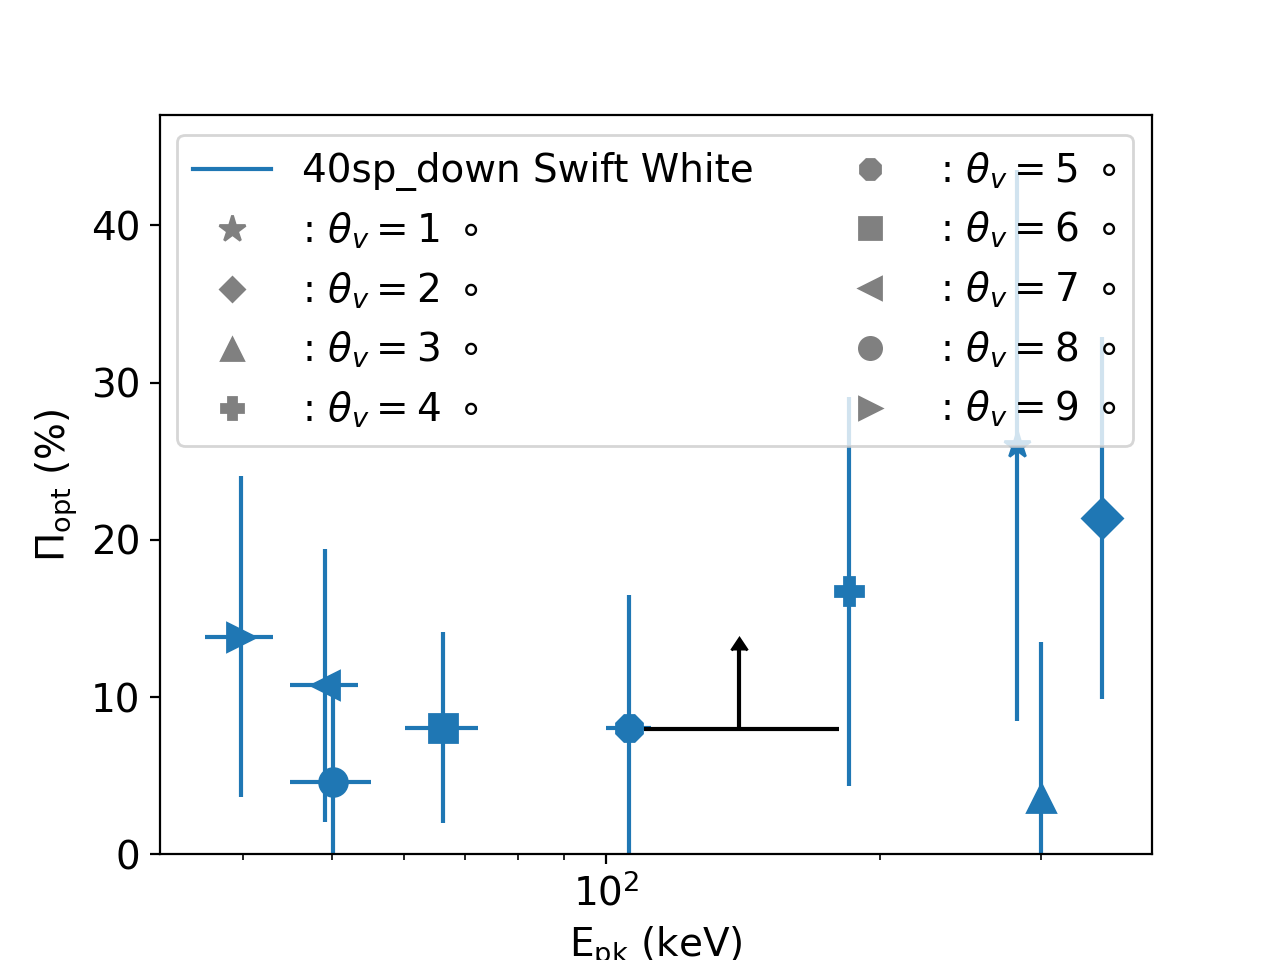

Text(0, 0.5, '$\\Pi_\\mathrm{opt}$ (%)')

In [65]:
fig, ax=pm.plot_polarization_peak_energy(spec_dict_list, pol_dict_list, labels=['40sp_down Swift White']) 
troja_data_epk=140
troja_data_epk_errors=[30,40]
troja_data_pol=8
lolims=np.array([1], dtype=bool) #this says that the polarization is a lower limit
ax.errorbar(troja_data_epk, troja_data_pol, xerr=np.array([troja_data_epk_errors]).T, yerr=5, lolims=lolims, color='k', zorder=4, markersize=10)
ax.set_ylabel(r'$\Pi_\mathrm{opt}$ (%)')

print out spectral fit parameters for comparison in this next section of the notebook

In [256]:
for i in spec_dict_list:
    peak_e, peak_e_err = pm.calc_epk_error(i['fit']['alpha'], i['fit']['break_energy'],\
                                        alpha_error=i['fit_errors']['alpha_errors'],\
                                        break_energy_error=i['fit_errors']['break_energy_errors'])
    print(fr'{i["theta_observer"]} $\alpha$:{i["fit"]["alpha"]} $\pm$ {i["fit_errors"]["alpha_errors"]} ')
    print(f'\t $\beta$:{i["fit"]["beta"]} $\pm$ {i["fit_errors"]["beta_errors"]} ')
    print(f'\t $\E_pk$:{peak_e} $\pm$ {peak_e_err}')

1.0 deg $\alpha$:-0.12774418996180945 $\pm$ 0.014400230008550475 
	 $eta$:-2.8652037023446106 $\pm$ 0.012416222115305145 
	 $\E_pk$:282.2204532609345 keV $\pm$ 4.643054622931347 keV
2.0 deg $\alpha$:-0.19095586035672163 $\pm$ 0.010660224206014007 
	 $eta$:-2.5626608926397108 $\pm$ 0.006561074927392112 
	 $\E_pk$:349.6560547553156 keV $\pm$ 4.72166092804803 keV
3.0 deg $\alpha$:-0.2716139906455116 $\pm$ 0.010706602422742916 
	 $eta$:-3.008740590846707 $\pm$ 0.013523303128677609 
	 $\E_pk$:300.28159927546585 keV $\pm$ 3.861977886369993 keV
4.0 deg $\alpha$:-0.381835065322112 $\pm$ 0.01707374667916252 
	 $eta$:-3.2827148630826564 $\pm$ 0.019283371788726814 
	 $\E_pk$:184.87170611577397 keV $\pm$ 4.163631801753304 keV
5.0 deg $\alpha$:-0.28101775934716333 $\pm$ 0.042177453542701075 
	 $eta$:-2.7616576842182448 $\pm$ 0.020003173189240223 
	 $\E_pk$:106.02486993052693 keV $\pm$ 6.028618172477022 keV
6.0 deg $\alpha$:-0.14357462981144933 $\pm$ 0.08265512654726662 
	 $eta$:-2.79188918959

# Now attempt to interface with 3ML using the ronswanson package

In [94]:
from typing import Dict

import numpy as np
#from astromodels import Band
import ronswanson as dukesilver

Now lets create a class that ustilizes ProcessMCRaT to obtain our simulation results and make them available to creating a table.

In [95]:
from pathlib import Path

class McratSimulation(dukesilver.Simulation):
    def __init__(
        self,
        simulation_id: int,
        mcrat_sim_dir: Path,
        mcrat_frame_num: int,
        parameter_set: Dict[str, float],
        energy_grid: np.ndarray,
        out_file: str,
    ) -> None:
        
        #need to get our dataset loaded with stokes parameters
        self.mcrat_sim=pm.McratSimLoad(str(mcrat_sim_dir)) 
        self.mcrat_sim.load_frame(mcrat_frame_num, read_stokes=True)
                
        super().__init__(simulation_id, parameter_set, energy_grid, out_file)

    def _run_call(self) -> np.ndarray:
        # how parameters are translated into
        # spectral output
        
        #need to specify observer location with respect to jet axis
        theta_deg=self._parameter_set["theta"]
        dtheta_deg=self._parameter_set["dtheta"]
        
        #need to specify location of observer, should not change
        r_obs=self._parameter_set["r_obs"]
        
        #need to specify the hydro frames per second, should not change
        fps=self._parameter_set["fps"]
        
        #need to specify the time bin min and max values, can be one time bin or many time bins
        tmin=self._parameter_set["tmin"]
        tmax=self._parameter_set["tmax"]
        
        
        #need to set our obsevation parameters
        observation=pm.MockObservation(theta_deg, dtheta_deg, r_obs, fps, mcratsimload_obj=self.mcrat_sim)
        
        #need to get spectral information, since we pass energy_bins this overrides the other energy bin info. 
        # these hav been kept for testing purposes
        spect_count_dict=observation.spectrum(tmin, tmax, spectrum_unit=unit.count/unit.s/unit.eV,\
                                      energy_range=[10**-7, 10**5]*unit.keV, delta_energy=1.26*unit.keV,
                                             energy_bins=self._energy_grid[0].grid*unit.keV)
        
        #NOTE: ronswanson expects N_ebins values for the number of points in the energy grid while the ProcessMCRaT
        #calculation assumes that these are enerbin bin edges so it returns (N_ebins-1) values.
        #therefore need to pad the ProcessMCRaT spectrum with a 0 since np.nan seems to give errors
        
        #output_0 is the photon count spectrum in units of photons/s/keV
        #output_1 is the polarization degree
        #output_2 is the polarization angle in degrees
        #output_3 is the polarization degree error
        #output_4 is the polarization angle error in degrees
        #self._energy_grid[0].grid=spect_count_dict['energy_bin_center']
        self.spectrum=np.pad(spect_count_dict['spectrum'], (0,self._energy_grid[0].grid.size-spect_count_dict['spectrum'].size), 'constant', constant_values=0)
        self.spectrum_err=spect_count_dict['spectrum_errors']
        self.polarization_deg=spect_count_dict['pol_deg']
        self.polarization_ang=spect_count_dict['pol_angle']
        self.polarization_deg_err=spect_count_dict['pol_deg_errors']
        self.polarization_ang_err=spect_count_dict['pol_angle_errors']


    
        #return dict(output_0=self.spectrum, output_1=self.polarization_deg, output_2=self.polarization_ang, 
        #           output_3=self.spectrum_err, output_4=self.polarization_deg_err, output_5=self.polarization_ang_err)
        return dict(output_0=self.spectrum)

In [96]:
import ronswanson
from ronswanson import ParameterGrid
sb = ronswanson.SimulationBuilder.from_yaml("sim_build.yml") #this sets up the database.h5 file and parameters.yml file
#pg = ParameterGrid.from_yaml('test_params.yml') #replace this with run_simulation.py info
#n_points = pg.n_points

20:50:07 WARNING   There was already a database: database.h5                              ]8;id=958740;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/ronswanson/simulation_builder.py\simulation_builder.py]8;;\:]8;id=451648;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/ronswanson/simulation_builder.py#426\426]8;;\

         WARNING   a copy will be made to ./database_copy.h5[lue]                         ]8;id=633576;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/ronswanson/simulation_builder.py\simulation_builder.py]8;;\:]8;id=821536;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/ronswanson/simulation_builder.py#447\447]8;;\

         WARNING   The existing data base had 9 entries                                   ]8;id=342329;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/ronswanson/simulation_builder.py\simulation_builder.py]8;;\:]8;id=446878;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/ronswanson/simulation_builder.py#459\459]8;;\

In [97]:
#Thsi is copied from a past run_simulation.py that was created in the cell above
import json
import h5py
import numpy as np
from tqdm.auto import tqdm
from ronswanson import ParameterGrid
from ronswanson.utils.logging import setup_logger
from ronswanson.utils import Colors
from ronswanson.simulation import gather
log = setup_logger(__name__)

pg = ParameterGrid.from_yaml('/Users/tparsotan/Library/CloudStorage/Box-Box/Theory-Interface/parameters.yml')
n_points = pg.n_points
def func(i, silent: bool=True):
    params = pg.at_index(i)
    if not silent:
        log.info(f'{params}')
    simulation = McratSimulation(i, str(Path().cwd())+"/", 1999, params, pg.energy_grid,'/Users/tparsotan/Library/CloudStorage/Box-Box/Theory-Interface/database.h5')
    simulation.run()
iteration = [i for i in range(0, n_points)]
Parallel(n_jobs=1)(delayed(func)(i) for i in tqdm(iteration, colour=Colors.RED.value, desc='simulating function'))
gather('/Users/tparsotan/Library/CloudStorage/Box-Box/Theory-Interface/database.h5', 0, clean=True)


simulating function:   0%|          | 0/9 [00:00<?, ?it/s]

Gathering simulations:   0%|          | 0/9 [00:00<?, ?it/s]

Now try to read in the database

In [98]:
from ronswanson import Database
db = Database.from_file("./database.h5")
print(db.parameter_ranges)
db.plot_runtime()


OrderedDict([('dtheta', array([0., 1.], dtype=float32)), ('fps', array([ 0., 10.], dtype=float32)), ('r_obs', array([0.e+00, 1.e+14], dtype=float32)), ('theta', array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)), ('tmax', array([ 0., 40.], dtype=float32)), ('tmin', array([0.], dtype=float32))])


/Users/tparsotan/anaconda3/lib/python3.10/site-packages/ronswanson/database.py:658: RuntimeWarning: divide by zero encountered in log10
  parameter = np.log10(parameter)


ValueError: Invalid property specified for object of type plotly.graph_objs.Parcoords: 'unselected'

Did you mean "labelside"?

    Valid properties:
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        dimensions
            The dimensions (variables) of the parallel coordinates
            chart. 2..60 dimensions are supported.
        dimensiondefaults
            When used in a template (as
            layout.template.data.parcoords.dimensiondefaults), sets
            the default property values to use for elements of
            parcoords.dimensions
        domain
            :class:`plotly.graph_objects.parcoords.Domain` instance
            or dict with compatible properties
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        labelangle
            Sets the angle of the labels with respect to the
            horizontal. For example, a `tickangle` of -90 draws the
            labels vertically. Tilted labels with "labelangle" may
            be positioned better inside margins when
            `labelposition` is set to "bottom".
        labelfont
            Sets the font for the `dimension` labels.
        labelside
            Specifies the location of the `label`. "top" positions
            labels above, next to the title "bottom" positions
            labels below the graph Tilted labels with "labelangle"
            may be positioned better inside margins when
            `labelposition` is set to "bottom".
        legendgrouptitle
            :class:`plotly.graph_objects.parcoords.Legendgrouptitle
            ` instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        line
            :class:`plotly.graph_objects.parcoords.Line` instance
            or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        rangefont
            Sets the font for the `dimension` range values.
        stream
            :class:`plotly.graph_objects.parcoords.Stream` instance
            or dict with compatible properties
        tickfont
            Sets the font for the `dimension` tick values.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        
Did you mean "labelside"?

Bad property path:
unselected
^^^^^^^^^^

Try to create the 3ML table

In [99]:
table_model = db.to_3ml("my_model", "a new model for 3ML")
table_model

20:50:31 WARNING   Energy unit is not a Quantity instance, so units has not been provided.    ]8;id=929670;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/astromodels/functions/template_model.py\template_model.py]8;;\:]8;id=412886;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/astromodels/functions/template_model.py#106\106]8;;\
                  Using keV.                                                                                       

         ERROR     A grid for a parameter must contain at least two elements                  ]8;id=93277;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/astromodels/functions/template_model.py\template_model.py]8;;\:]8;id=250059;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/astromodels/functions/template_model.py#153\153]8;;\

AssertionError: 

Instead try to just load in the MCRaT spectrum as a model to be used in fitting to a set of datapoints

In [100]:
from astromodels import TemplateModelFactory

In [257]:
theta_deg=[1,2,3,4,5,6,7,8,9]
dtheta_deg=1
r_obs=1e14
fps=10

energies = np.logspace(0, 3, 500)

#need to get our dataset loaded with stokes parameters
mcrat_sim=pm.McratSimLoad() 
mcrat_sim.load_frame(1999, read_stokes=True)

def construct_spectra(theta_v):
    #need to set our obsevation parameters
    observation=pm.MockObservation(theta_v, dtheta_deg, r_obs, fps, mcratsimload_obj=mcrat_sim)

    #need to get spectral information, since we pass energy_bins this overrides the other energy bin info. 
    # these hav been kept for testing purposes
    spect_count_dict=observation.spectrum(0, 40, spectrum_unit=unit.count/unit.s/unit.eV,\
                              energy_range=[10**-7, 10**5]*unit.keV, delta_energy=1.26*unit.keV,
                                     energy_bins=energies*unit.keV)
    spect=np.pad(spect_count_dict['spectrum'].value, (0,energies.size-spect_count_dict['spectrum'].size), 'constant', constant_values=0)
    return spect
  
tmf = TemplateModelFactory("my_template", "A test template", energies, ["theta_v"])

In [258]:
tmf.define_parameter_grid("theta_v", theta_deg)

for i in theta_deg:
    
    spect = construct_spectra(i)
    
    
    tmf.add_interpolation_data(spect, theta_v=i)

In [260]:
tmf.save_data()

In [134]:
from astromodels import TemplateModel

In [261]:
xx = TemplateModel("my_template")

Can access differnt spectra that are saved by specifying theta_v

In [150]:
xx.theta_v = 9

Can also set non-specified theta_v such that interpolation takes place

In [151]:
xx.theta_v = 6.5

Can now try to do a test fit to data

In [152]:
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")
import astropy.units as u
from threeML import *
from threeML.utils.OGIP.response import OGIPResponse
from threeML.io.package_data import get_path_of_data_file

08:40:58 INFO      Starting 3ML!                                                                     ]8;id=727651;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=556623;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=157369;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=188849;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=267994;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=267504;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=122112;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=245472;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   no display variable set. using backend for graphics without display (agg)         ]8;id=844244;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=552471;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py#46\46]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=707599;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=779300;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=883837;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=942709;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=90273;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=447310;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

08:40:58 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=173532;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=206604;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=839105;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=619643;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=67159;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=14624;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

08:40:59 WARNING   No fermitools installed                                              ]8;id=802233;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=545846;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

08:40:59 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=561;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=111579;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=86894;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=717893;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=523742;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=239438;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

13:57:50 INFO      Auto-probed noise models:                                                    ]8;id=669161;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=321807;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=219169;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=607537;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=700562;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=993015;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 8-900 translates to channels 2-124                                    ]8;id=83219;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=668960;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=119588;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=511184;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=249832;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=333720;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=808239;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=664219;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=522426;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=195320;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

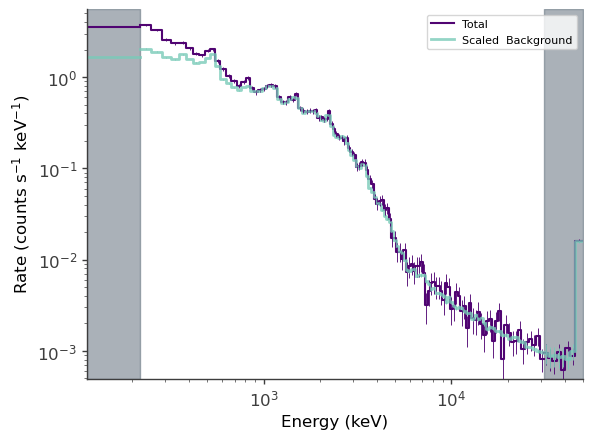

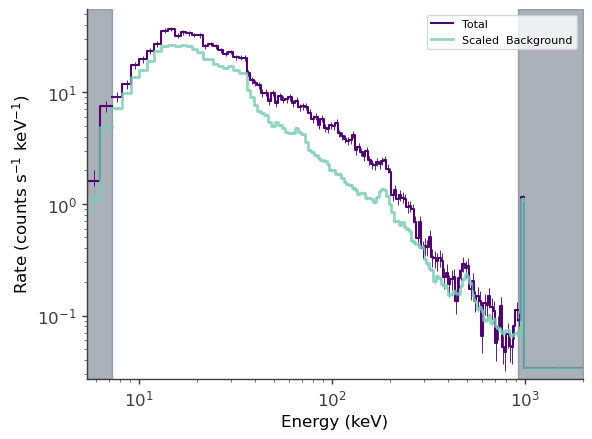

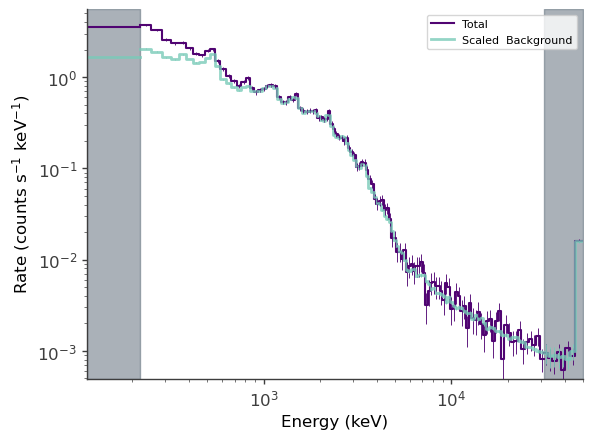

In [263]:
#this loads in full spectrum observed by different GBM detectors
nai6 = OGIPLike(
    "n6",
    get_path_of_data_file("datasets/gbm/gbm_bat_joint_NAI_06.pha"),
    get_path_of_data_file("datasets/gbm/gbm_bat_joint_NAI_06.bak"),
    get_path_of_data_file("datasets/gbm/gbm_bat_joint_NAI_06.rsp"),
    spectrum_number=1,
)


nai6.set_active_measurements("8-900")
nai6.view_count_spectrum()

bgo0 = OGIPLike(
    "b0",
    get_path_of_data_file("datasets/gbm/gbm_bat_joint_BGO_00.pha"),
    get_path_of_data_file("datasets/gbm/gbm_bat_joint_BGO_00.bak"),
    get_path_of_data_file("datasets/gbm/gbm_bat_joint_BGO_00.rsp"),
    spectrum_number=1,
)

bgo0.set_active_measurements("250-30000")
bgo0.view_count_spectrum()

14:01:56 INFO      Auto-probed noise models:                                                    ]8;id=253219;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=396218;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=611326;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=502084;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: None                                                           ]8;id=565924;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=333441;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=814836;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=377032;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=430639;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=254925;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: None                                                           ]8;id=751887;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=476769;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=100796;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=813972;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=9786;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=473364;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: poisson                                                        ]8;id=498609;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=877523;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=264113;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=20172;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=729808;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=700055;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: poisson                                                        ]8;id=824020;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=250430;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

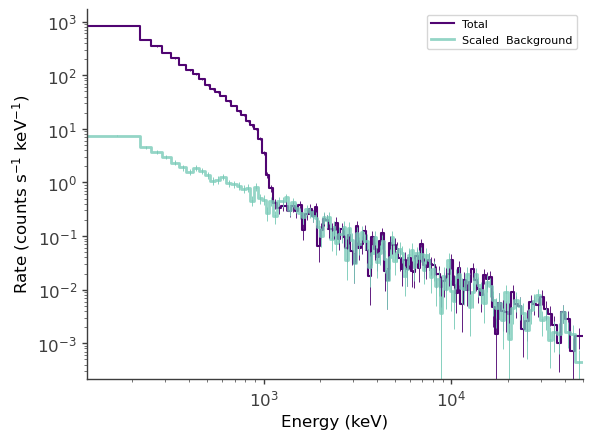

In [268]:
#just fold the MCRaT spectrum through one BGO detector, can expand to multiple detectors
response_2 = OGIPResponse(get_path_of_data_file("datasets/gbm/gbm_bat_joint_BGO_00.rsp"))

xx.theta_v = 1
xx.K = 1e-55
source_function_2 = xx 
background_function_2 = Powerlaw(K=1, index=-1.5, piv=1.0e3)


spectrum_generator_2 = DispersionSpectrumLike.from_function(
    "s2",
    source_function=source_function_2,
    background_function=background_function_2,
    response=response_2,
)

fig = spectrum_generator_2.view_count_spectrum()

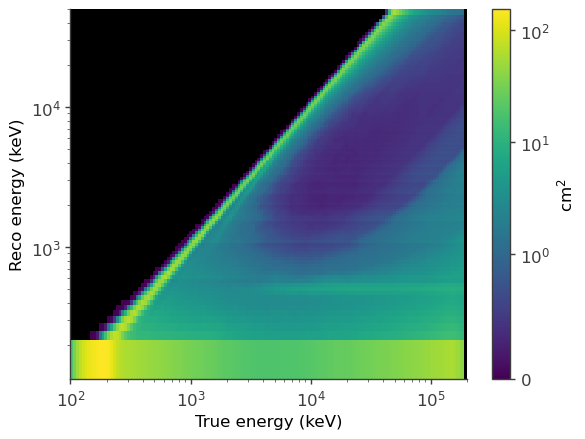

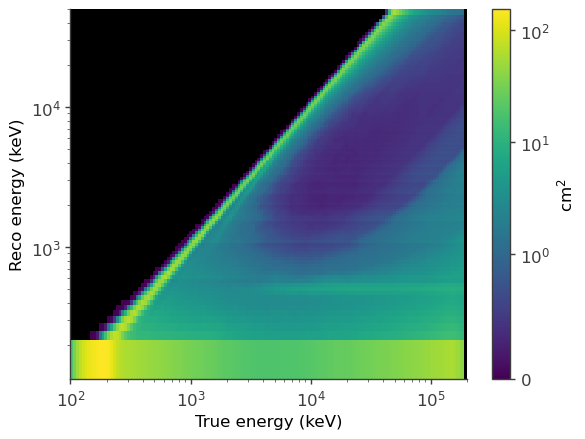

In [269]:
spectrum_generator_2.response.plot_matrix()

In [267]:
ps2 = PointSource("src", ra=0, dec=0, spectral_shape=xx)
model = Model(ps2)
model.plot_tree()

model
┗━━ ✨ src 
    ┣━━ 🔭 position
    ┃   ┣━━ ra
    ┃   ┗━━ dec
    ┗━━ 🌈 spectrum
        ┗━━ main
            ┣━━ my_template
            ┃   ┣━━ K
            ┃   ┣━━ scale
            ┃   ┗━━ theta_v
            ┗━━ polarization

In [270]:
data = DataList(spectrum_generator_2)

set up priors

In [271]:
xx.K.fix = 1e-55
xx.scale.fix = True
xx.theta_v.prior = Uniform_prior(lower_bound=1, upper_bound=9)

In [272]:
# This doesnt work since we havent assigned priors to theta_v, etc in xx: 
# see https://threeml.readthedocs.io/en/stable/notebooks/flux_examples.html
silence_warnings()
%matplotlib inline
ba = BayesianAnalysis(model, data)
ba.set_sampler("emcee")
ba.sampler.setup(n_iterations=500)
_ = ba.sample()

14:02:30 INFO      sampler set to emcee                                                    ]8;id=956453;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=439132;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

14:03:27 INFO      Mean acceptance fraction: 0.8125                                            ]8;id=525639;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/emcee_sampler.py\emcee_sampler.py]8;;\:]8;id=936592;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/emcee_sampler.py#157\157]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=584768;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=581521;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=329297;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=978664;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result unit
parameter                                                  
src.spectrum.main.my_template.theta_v  1.037 +/- 0.014

Values of -log(posterior) at the minimum:

-log(posterior)
s2         -623.331615
total      -623.331615

Values of statistical measures:

statistical measures
AIC            1248.694975
BIC            1251.515259
DIC            1248.500356
PDIC              0.918372

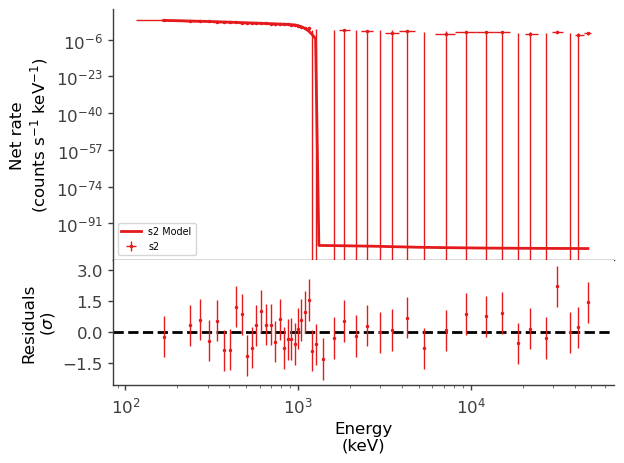

In [273]:
fig = display_spectrum_model_counts(ba)

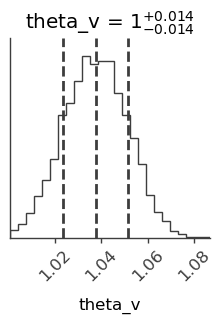

In [274]:
result = ba.results
fig = result.corner_plot()

# Can also try to use the MCRaT spectrum as "mock observed" data

04:54:28 INFO      Auto-probed noise models:                                                    ]8;id=92198;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=681694;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=726730;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=551716;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: None                                                           ]8;id=811976;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=217390;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=793157;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=405502;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=912900;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=667287;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: None                                                           ]8;id=139213;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=351873;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

04:54:29 INFO      Range 250-30000 translates to channels 1-119                                ]8;id=78608;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=166412;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#1210\1210]8;;\


WARNING UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.



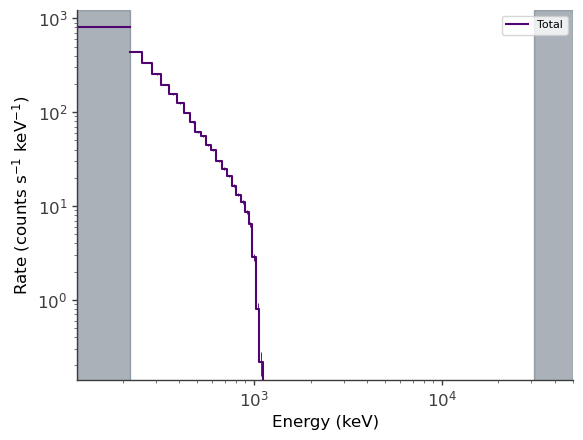

In [302]:
xx.theta_v = 1
xx.K = 1e-55
source_function_2 = xx 

#response_2 = OGIPResponse(get_path_of_data_file("datasets/ogip_powerlaw.rsp"))
#just fold the MCRaT spectrum through one BGO detector, can expand to multiple detectors
response_2 = OGIPResponse(get_path_of_data_file("datasets/gbm/gbm_bat_joint_BGO_00.rsp"))

mc_spectrum_generator_2 = DispersionSpectrumLike.from_function(
    "s2",
    source_function=source_function_2,
    response=response_2,
)

#set range for BGO
mc_spectrum_generator_2.set_active_measurements("250-30000")


fig = mc_spectrum_generator_2.view_count_spectrum()

Also add a NCI detector measurment as well

04:54:52 INFO      Auto-probed noise models:                                                    ]8;id=206717;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=734891;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=633333;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=643000;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: None                                                           ]8;id=741807;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=896132;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=750433;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=217381;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=898505;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=509903;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: None                                                           ]8;id=52930;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=517306;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

04:54:53 INFO      Range 8-900 translates to channels 2-124                                    ]8;id=336495;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=279272;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/plugins/SpectrumLike.py#1210\1210]8;;\


WARNING UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.



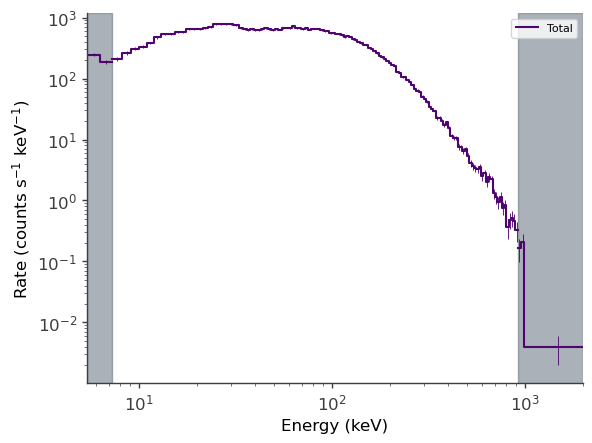

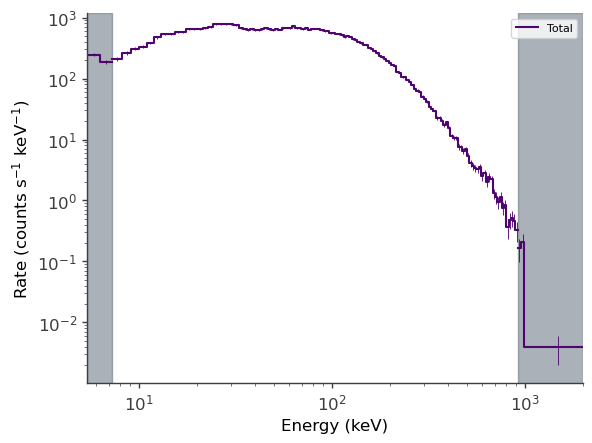

In [304]:
#also add NI instrument dectection
response_1 = OGIPResponse(get_path_of_data_file("datasets/gbm/gbm_bat_joint_NAI_06.rsp"))

mc_spectrum_generator_1 = DispersionSpectrumLike.from_function(
    "s1",
    source_function=source_function_2,
    response=response_1,
)

mc_spectrum_generator_1.set_active_measurements("8-900")
mc_spectrum_generator_1.view_count_spectrum()

In [305]:
band = Band()
model_no_eac = Model(PointSource("joint_fit_no_eac", 0, 0, spectral_shape=band))

In [306]:
data_list = DataList(mc_spectrum_generator_1, mc_spectrum_generator_2)

In [307]:
jl_no_eac = JointLikelihood(model_no_eac, data_list)
jl_no_eac.fit()

04:59:13 INFO      set the minimizer to minuit                                             ]8;id=872793;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=899462;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

Best fit values:

result  \
parameter                                                               
joint_fit_no_eac.spectrum.main.Band.K          (1.250 +/- 0.007) x 10   
joint_fit_no_eac.spectrum.main.Band.alpha    (-2.49 +/- 0.06) x 10^-1   
joint_fit_no_eac.spectrum.main.Band.xp       (3.039 +/- 0.009) x 10^2   
joint_fit_no_eac.spectrum.main.Band.beta   -5.00000000 +/- 0.00000023   

                                                      unit  
parameter                                                   
joint_fit_no_eac.spectrum.main.Band.K      1 / (cm2 keV s)  
joint_fit_no_eac.spectrum.main.Band.alpha                   
joint_fit_no_eac.spectrum.main.Band.xp                 keV  
joint_fit_no_eac.spectrum.main.Band.beta

Correlation matrix:

1.00  0.68 -0.88  0.00
 0.68  1.00 -0.54  0.00
-0.88 -0.54  1.00 -0.00
 0.00  0.00 -0.00  1.00

Values of -log(likelihood) at the minimum:

-log(likelihood)
s1           742.297330
s2          1079.056915
total       1821.354245

Values of statistical measures:

statistical measures
AIC           3650.877267
BIC           3664.664241

(                                                value  negative_error  \
 joint_fit_no_eac.spectrum.main.Band.K       12.504861   -6.968077e-02   
 joint_fit_no_eac.spectrum.main.Band.alpha   -0.249156   -6.052028e-03   
 joint_fit_no_eac.spectrum.main.Band.xp     303.887767   -9.316944e-01   
 joint_fit_no_eac.spectrum.main.Band.beta    -5.000000    4.892651e-08   
 
                                            positive_error         error  \
 joint_fit_no_eac.spectrum.main.Band.K        7.492738e-02  7.230408e-02   
 joint_fit_no_eac.spectrum.main.Band.alpha    6.233623e-03  6.142825e-03   
 joint_fit_no_eac.spectrum.main.Band.xp       8.987087e-01  9.152015e-01   
 joint_fit_no_eac.spectrum.main.Band.beta     3.404619e-07  1.946942e-07   
 
                                                       unit  
 joint_fit_no_eac.spectrum.main.Band.K      1 / (cm2 keV s)  
 joint_fit_no_eac.spectrum.main.Band.alpha                   
 joint_fit_no_eac.spectrum.main.Band.xp                 keV 

In [326]:
band.K.fix = True

band.xp.prior= Uniform_prior(lower_bound=10, upper_bound=1000)
band.piv.prior= Uniform_prior(lower_bound=0, upper_bound=1000)
band.alpha.set_uninformative_prior(Uniform_prior) # = Uniform_prior(lower_bound=-3, upper_bound=3)
band.beta.prior = Uniform_prior(lower_bound=-15, upper_bound=0)

band.beta.bounds = (None, None)

band

* description: Band model from Band et al., 1993, parametrized with the peak energy
  * formula: $K \begin{cases} \left(\frac{x}{piv}\right)^{\alpha} \exp \left(-\frac{(2+\alpha)
    * x}{x_{p}}\right) & x \leq (\alpha-\beta) \frac{x_{p}}{(\alpha+2)} \\ \left(\frac{x}{piv}\right)^{\beta}
    * \exp (\beta-\alpha)\left[\frac{(\alpha-\beta) x_{p}}{piv(2+\alpha)}\right]^{\alpha-\beta}
    * &x>(\alpha-\beta) \frac{x_{p}}{(\alpha+2)} \end{cases} $
  * parameters:
    * K:
      * value: 12.50486069350228
      * desc: Differential flux at the pivot energy
      * min_value: 1.0e-99
      * max_value: null
      * unit: keV-1 s-1 cm-2
      * is_normalization: true
      * delta: 1.0e-05
      * free: false
    * alpha:
      * value: -0.24763247711669242
      * desc: low-energy photon index
      * min_value: -1.5
      * max_value: 3.0
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
      * prior:
        * Uniform_prior:
          * lower_bound:
            * value: -1.5
            * desc: Lower bound for the interval
            * min_value: -.inf
            * max_value: .inf
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
          * upper_bound:
            * value: 3.0
            * desc: Upper bound for the interval
            * min_value: -.inf
            * max_value: .inf
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
          * value:
            * value: 1.0
            * desc: Value in the interval
            * min_value: null
            * max_value: null
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
    * xp:
      * value: 304.94500002907887
      * desc: peak in the x * x * N (nuFnu if x is a energy)
      * min_value: 10.0
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 50.0
      * free: true
      * prior:
        * Uniform_prior:
          * lower_bound:
            * value: 10.0
            * desc: Lower bound for the interval
            * min_value: -.inf
            * max_value: .inf
            * unit: keV
            * is_normalization: false
            * delta: 0.1
            * free: true
          * upper_bound:
            * value: 1000.0
            * desc: Upper bound for the interval
            * min_value: -.inf
            * max_value: .inf
            * unit: keV
            * is_normalization: false
            * delta: 0.1
            * free: true
          * value:
            * value: 1.0
            * desc: Value in the interval
            * min_value: null
            * max_value: null
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
    * beta:
      * value: -14.82466991827363
      * desc: high-energy photon index
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.2
      * free: true
      * prior:
        * Uniform_prior:
          * lower_bound:
            * value: -15.0
            * desc: Lower bound for the interval
            * min_value: -.inf
            * max_value: .inf
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
          * upper_bound:
            * value: 0.0
            * desc: Upper bound for the interval
            * min_value: -.inf
            * max_value: .inf
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
          * value:
            * value: 1.0
            * desc: Value in the interval
            * min_value: null
            * max_value: null
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
    * piv:
      * value: 100.0
      * desc: pivot energy
      * min_value: n

In [323]:
silence_warnings()
ba = BayesianAnalysis(model_no_eac, data_list)
ba.set_sampler("emcee")
ba.sampler.setup(n_iterations=500)
_ = ba.sample()

05:15:41 INFO      sampler set to emcee                                                    ]8;id=293985;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=409851;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

05:15:58 INFO      Mean acceptance fraction: 0.6151000000000001                                ]8;id=268922;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/emcee_sampler.py\emcee_sampler.py]8;;\:]8;id=169739;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/emcee_sampler.py#157\157]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=696235;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=344994;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=412892;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=208584;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result unit
parameter                                                                   
joint_fit_no_eac.spectrum.main.Band.alpha      (-2.48 +/- 0.05) x 10^-1     
joint_fit_no_eac.spectrum.main.Band.xp     (3.049 -0.005 +0.004) x 10^2  keV
joint_fit_no_eac.spectrum.main.Band.beta        (-1.48 +0.07 +0.4) x 10

Values of -log(posterior) at the minimum:

-log(posterior)
s1         -740.171689
s2         -817.498595
total     -1557.670284

Values of statistical measures:

statistical measures
AIC            3121.441409
BIC            3131.807382
DIC            3120.319397
PDIC              2.431792

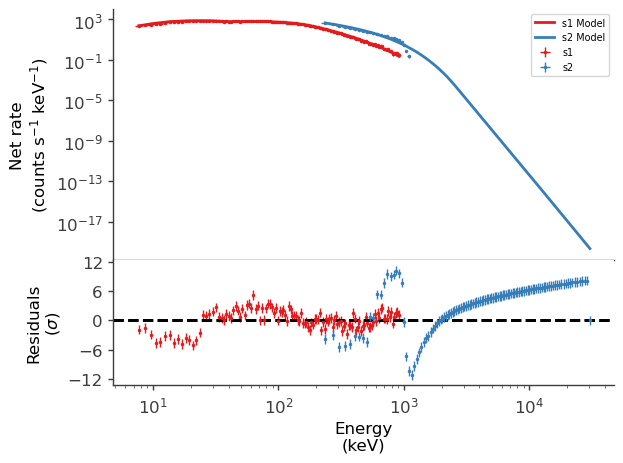

In [324]:
fig = display_spectrum_model_counts(ba)

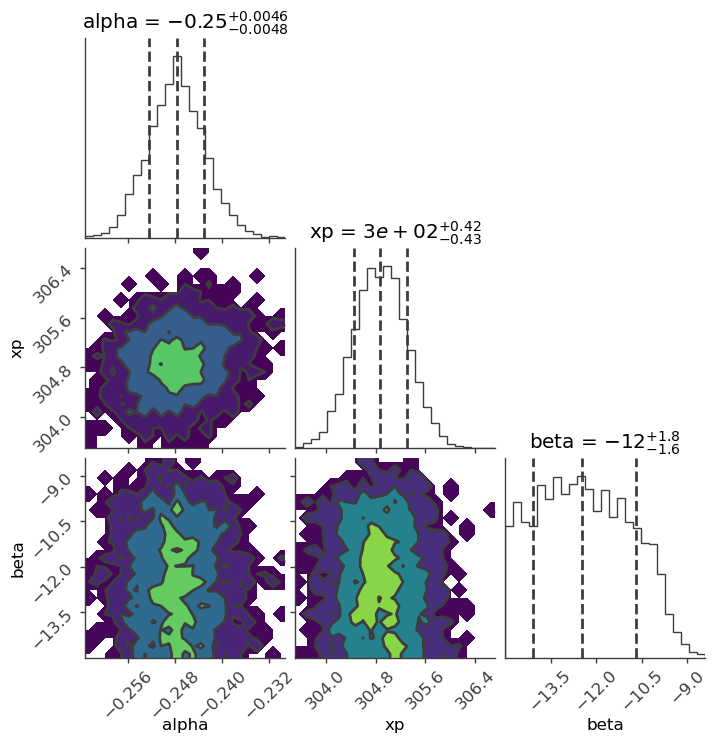

In [325]:
result = ba.results
fig = result.corner_plot()

# Now want to try to use MCRaT spectrum as observed data and fit the MCRaT folded spectrum with ramandeeps database to see what synchrotron parameters best fit the spectrum

First load in the database:

In [328]:
#note that the database current has spectral units of flux and not photons
db = Database.from_file("database-ramandeep.h5")
print(db.parameter_ranges)
table_model = db.to_3ml("ramandeep_model", "Ramandeep  model for 3ML", overwrite=True)

OrderedDict([('alpha', array([-1.        , -0.8888889 , -0.7777778 , -0.6666667 , -0.5555556 ,
       -0.44444445, -0.33333334, -0.22222222, -0.11111111,  0.        ],
      dtype=float32)), ('beta', array([-3.       , -2.8888888, -2.7777777, -2.6666667, -2.5555556,
       -2.4444444, -2.3333333, -2.2222223, -2.1111112, -2.       ],
      dtype=float32)), ('epeak', array([  10.   ,   50.   ,   69.74 ,   97.29 ,  135.72 ,  189.32 ,
        264.097,  368.4  ,  513.9  ,  716.87 , 1000.   ], dtype=float32)), ('qview', array([0. , 0.5, 1. , 1.5, 2. ], dtype=float32))])


building table model:   0%|          | 0/5500 [00:00<?, ?it/s]

In [333]:
model = Model(PointSource("my_model", 0, 0, spectral_shape=table_model))
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (6):
--------------------

                                               value min_value max_value  \
my_model.spectrum.main.ramandeep_model.K         1.0      None      None   
my_model...scale                                 1.0      None      None   
my_model...alpha                                -0.5      -1.0       0.0   
my_model...beta                                 -2.5      -3.0      -2.0   
my_model...epeak                          189.320007      10.0    1000.0   
my_model...qview                                 1.0       0.0       2.0   

                                                    unit  
my_model.spectrum.main.ramandeep_model.K  keV-1 s-1 cm-2  
my_model...scale                                   keV-1  
my_model...alpha                                          
my_model...beta                                           
my_model...epeak                                          
my_model...qview                                          

Fixed parameters (2):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

Now set priors on the table model parameters

In [342]:
#model.K.fix = True
table_model.K.bounds = (1e-10, None)
table_model.K.prior = Log_uniform_prior(lower_bound=1e-5, upper_bound=1e2)

table_model.scale.fix = True

table_model.epeak.prior = Log_uniform_prior(lower_bound=10, upper_bound=1000)
table_model.alpha.prior = Uniform_prior(lower_bound=-1, upper_bound=0)
table_model.beta.prior = Uniform_prior(lower_bound=-3, upper_bound=-2)
table_model.qview.prior = Uniform_prior(lower_bound=0, upper_bound=2)


table_model.beta.bounds = (None, None)

table_model

* description: Ramandeep  model for 3ML
  * formula: n.a.
  * parameters:
    * K:
      * value: 1.0
      * desc: None
      * min_value: 1.0e-10
      * max_value: null
      * unit: keV-1 s-1 cm-2
      * is_normalization: false
      * delta: 0.1
      * free: true
      * prior:
        * Log_uniform_prior:
          * lower_bound:
            * value: 1.0e-05
            * desc: Lower bound for the interval
            * min_value: 1.0e-30
            * max_value: .inf
            * unit: keV-1 s-1 cm-2
            * is_normalization: false
            * delta: 1.0e-21
            * free: true
          * upper_bound:
            * value: 100.0
            * desc: Upper bound for the interval
            * min_value: 1.0e-30
            * max_value: .inf
            * unit: keV-1 s-1 cm-2
            * is_normalization: false
            * delta: 10.0
            * free: true
          * K:
            * value: 1.0
            * desc: Normalization
            * min_value: null
            * max_value: null
            * unit: keV-1 s-1 cm-2
            * is_normalization: false
            * delta: 0.1
            * free: false
    * scale:
      * value: 1.0
      * desc: None
      * min_value: null
      * max_value: null
      * unit: keV-1
      * is_normalization: false
      * delta: 0.1
      * free: false
    * alpha:
      * value: -0.5
      * desc: None
      * min_value: -1.0
      * max_value: 0.0
      * unit: ''
      * is_normalization: false
      * delta: 0.05
      * free: true
      * prior:
        * Uniform_prior:
          * lower_bound:
            * value: -1.0
            * desc: Lower bound for the interval
            * min_value: -.inf
            * max_value: .inf
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
          * upper_bound:
            * value: 0.0
            * desc: Upper bound for the interval
            * min_value: -.inf
            * max_value: .inf
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
          * value:
            * value: 1.0
            * desc: Value in the interval
            * min_value: null
            * max_value: null
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
    * beta:
      * value: -2.5
      * desc: None
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.25
      * free: true
      * prior:
        * Uniform_prior:
          * lower_bound:
            * value: -3.0
            * desc: Lower bound for the interval
            * min_value: -.inf
            * max_value: .inf
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
          * upper_bound:
            * value: -2.0
            * desc: Upper bound for the interval
            * min_value: -.inf
            * max_value: .inf
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
          * value:
            * value: 1.0
            * desc: Value in the interval
            * min_value: null
            * max_value: null
            * unit: ''
            * is_normalization: false
            * delta: 0.1
            * free: true
    * epeak:
      * value: 189.32000732421875
      * desc: None
      * min_value: 10.0
      * max_value: 1000.0
      * unit: ''
      * is_normalization: false
      * delta: 18.932000732421876
      * free: true
      * prior:
        * Log_uniform_prior:
          * lower_bound:
            * value: 10.0
            * desc: Lower bound for the interval
            * min_value: 1.0e-30
            * max_value: .inf
            * unit: ''
            * is_normalization: false
            * delta: 1.0e-21
            * free: true
          * upper_bound:
            * value: 1000.0
        

Now try to do the fit

07:23:11 INFO      sampler set to emcee                                                    ]8;id=996987;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=327878;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

07:23:47 INFO      Mean acceptance fraction: 0.24509999999999996                               ]8;id=361311;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/emcee_sampler.py\emcee_sampler.py]8;;\:]8;id=500413;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/emcee_sampler.py#157\157]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=552455;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=472284;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

07:23:48 INFO      fit restored to maximum of posterior                                         ]8;id=134500;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=300125;file:///Users/tparsotan/anaconda3/lib/python3.10/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                    
my_model.spectrum.main.ramandeep_model.K                       6.7 -5 -0.9   
my_model.spectrum.main.ramandeep_model.alpha  (-2.711 +0.013 +2.5) x 10^-1   
my_model.spectrum.main.ramandeep_model.beta       -2.99999 +0.00010 +0.005   
my_model.spectrum.main.ramandeep_model.epeak          (4.33 +0.21 +8) x 10   
my_model.spectrum.main.ramandeep_model.qview       (9.98 -4 +0.05) x 10^-1   

                                                         unit  
parameter                                                      
my_model.spectrum.main.ramandeep_model.K      1 / (cm2 keV s)  
my_model.spectrum.main.ramandeep_model.alpha                   
my_model.spectrum.main.ramandeep_model.beta                    
my_model.spectrum.main.ramandeep_model.epeak                   
my_model.spectrum.main.ramandeep_model.qview

Values of -log(posterior) at the minimum:

-log(posterior)
s1      -141203.462866
s2       -91396.992370
total   -232600.455236

Values of statistical measures:

statistical measures
AIC          465211.164708
BIC          465228.355160
DIC          440121.693248
PDIC         -49229.669888

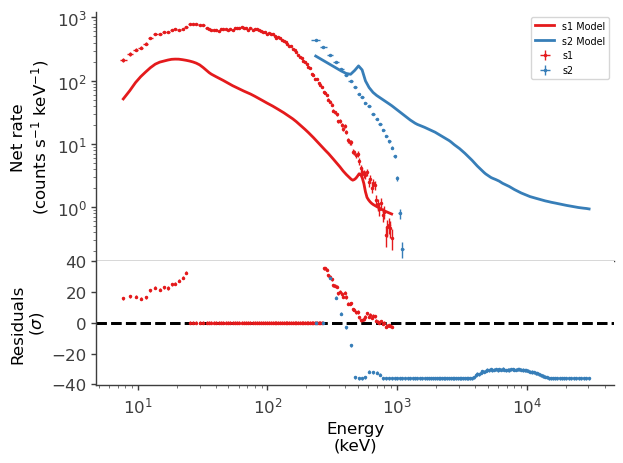

In [343]:
silence_warnings()
ba = BayesianAnalysis(model, data_list)
ba.set_sampler("emcee")
ba.sampler.setup(n_iterations=500)
_ = ba.sample()
fig = display_spectrum_model_counts(ba)

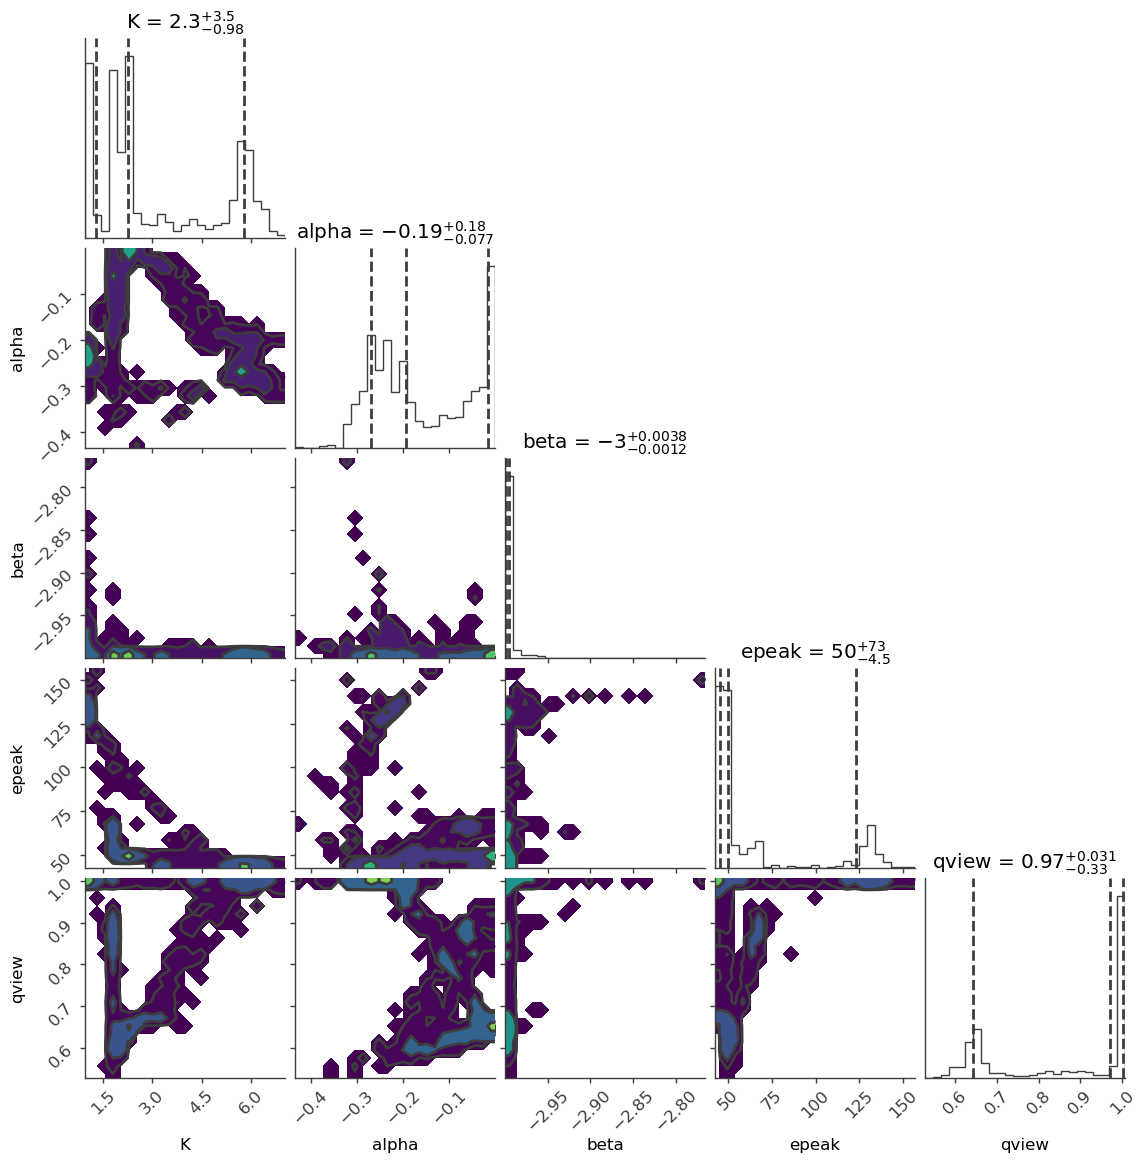

In [344]:
result = ba.results
fig = result.corner_plot()

In [339]:
table_model?